# Part 0: Libraries

In [1]:
import io
from IPython.display import display

import pathlib
from pathlib import Path as path

import pandas as pd
import numpy as np

import math
from math import atan2

import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString, GeometryCollection

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import seaborn as sns
sns.set(style = 'darkgrid', context = 'talk')

import warnings
warnings.filterwarnings('ignore')

import imblearn
from imblearn.over_sampling import SMOTE

import xgboost as xgb

import pickle


# Part 1: Import Data from JSON

## Matches

In [2]:
# Define path for stored StatsBomb Open Data Matches
matches_path = './final_statsbomb_data/matches/FAWSL_22_23.json'

# Mapping for later
match_events_mapping = {"3856040": "ManCity_Tottenham", "3856030": "ManCity_AstonVilla", 
                        "3855961": "ManCity_Liverpool", "3855980": "ManCity_Brighton", 
                        "3855947": "ManCity_LeicesterCity", "3852832": "ManCity_Arsenal"}
    
# Create dataframe from data contained in FAWSL Matches file
matches_list = []
matches_data = pd.read_json(matches_path)
matches_list.append(matches_data)

matches_df = pd.concat(matches_list, ignore_index = True)
print('Total Matches:', len(matches_df))
matches_df.head()

Total Matches: 132


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,attendance,...,play_status,match_status,match_status_360,last_updated,last_updated_360,metadata,match_week,competition_stage,stadium,referee
0,3856041,2023-03-05,14:30:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 235, 'season_name': '2022/2023'}","{'home_team_id': 1475, 'home_team_name': 'Manc...","{'away_team_id': 2652, 'away_team_name': 'Leic...",5.0,1.0,NaN,...,Normal,available,unscheduled,2023-03-07T01:18:06.866218,NaN,"{'data_version': '1.1.0', 'shot_fidelity_versi...",14,"{'id': 1, 'name': 'Regular Season'}","{'id': 4979, 'name': 'Leigh Sports Village Sta...","{'id': 1004975, 'name': 'Melissa Burgin', 'cou..."
1,3856039,2023-03-05,15:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 235, 'season_name': '2022/2023'}","{'home_team_id': 967, 'home_team_name': 'Evert...","{'away_team_id': 2647, 'away_team_name': 'Asto...",0.0,2.0,NaN,...,Normal,available,unscheduled,2023-03-06T02:32:24.174447,NaN,"{'data_version': '1.1.0', 'shot_fidelity_versi...",14,"{'id': 1, 'name': 'Regular Season'}","{'id': 4989, 'name': 'Walton Hall Park', 'coun...","{'id': 898, 'name': 'Amy Fearn', 'country': {'..."
2,3852829,2023-02-12,14:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 235, 'season_name': '2022/2023'}","{'home_team_id': 749, 'home_team_name': 'Totte...","{'away_team_id': 1475, 'away_team_name': 'Manc...",1.0,2.0,NaN,...,Normal,available,unscheduled,2023-02-15T06:41:39.185889,NaN,"{'data_version': '1.1.0', 'shot_fidelity_versi...",1,"{'id': 1, 'name': 'Regular Season'}","{'id': 600, 'name': 'Tottenham Hotspur Stadium...","{'id': 898, 'name': 'Amy Fearn', 'country': {'..."
3,3856035,2023-02-05,14:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 235, 'season_name': '2022/2023'}","{'home_team_id': 1475, 'home_team_name': 'Manc...","{'away_team_id': 967, 'away_team_name': 'Evert...",0.0,0.0,NaN,...,Normal,available,unscheduled,2023-02-20T02:56:27.311794,NaN,"{'data_version': '1.1.0', 'shot_fidelity_versi...",13,"{'id': 1, 'name': 'Regular Season'}","{'id': 4979, 'name': 'Leigh Sports Village Sta...","{'id': 1711, 'name': 'Emily Heaslip', 'country..."
4,3856037,2023-02-05,20:45:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 235, 'season_name': '2022/2023'}","{'home_team_id': 972, 'home_team_name': 'West ...","{'away_team_id': 968, 'away_team_name': 'Arsen...",0.0,0.0,NaN,...,Normal,available,unscheduled,2023-02-19T05:14:26.996553,NaN,"{'data_version': '1.1.0', 'shot_fidelity_versi...",13,"{'id': 1, 'name': 'Regular Season'}","{'id': 116891, 'name': 'Chigwell Construction ...","{'id': 2127, 'name': 'Richie Watkins', 'countr..."


## Events

In [3]:
events_path = './final_statsbomb_data/events'

# Identifying match IDs from matches_df for matches from target leagues
match_ids_list = list(match_events_mapping.keys())

matches_list = []
for mi in match_ids_list:
    matches_list.append(mi)

# Create list of Events files for matches from target leagues
events_path_list = []
for m in matches_list:
    events_path_list.append(events_path +'/' + match_events_mapping[m] + '_events.json')

# Create dataframe from data in Events files
events_list = [] 
for ep in events_path_list:
    events_data = pd.read_json(ep)
    events_list.append(events_data)
    
events_df = pd.concat(events_list, ignore_index = True)

print('Total Events:', len(events_df))
print('Total Features:', events_df.shape[1])

events_df.head()

Total Events: 21332
Total Features: 46


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,off_camera,interception,foul_won,foul_committed,block,substitution,miscontrol,injury_stoppage,50_50,bad_behaviour
0,f887633b-6105-405b-b2ce-8d63ef617498,1,1,2023-04-22 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 746, 'name': 'Manchester City WFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6c650a51-cfe9-4214-909f-2328c643349a,2,1,2023-04-22 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 746, 'name': 'Manchester City WFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69c37df1-290a-4429-92a3-fbac21a133b9,3,1,2023-04-22 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 746, 'name': 'Manchester City WFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9771e240-fc05-4448-b7a6-2364c6555dde,4,1,2023-04-22 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 746, 'name': 'Manchester City WFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b81dcf83-537d-4f17-8f34-abb38d2dce13,5,1,2023-04-22 00:00:00.194,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 749, 'name': 'Tottenham Hotspur Women'}","{'id': 9, 'name': 'From Kick Off'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Save to CSV for Back Up

In [4]:
events_df.to_csv('./final_statsbomb_data/events_df.csv')
print('events_df Filesize:', path('./final_statsbomb_data/events_df.csv').stat().st_size, 'bytes')

matches_df.to_csv('./final_statsbomb_data/matches_df.csv')
print('matches_df Filesize:', path('./final_statsbomb_data/matches_df.csv').stat().st_size, 'bytes')

events_df Filesize: 12617251 bytes
matches_df Filesize: 135511 bytes


# Part 2: Organize Data

## Shot Data and Features

In [5]:
shots_df = events_df[events_df['shot'].notna()]

shots_df = shots_df[['index','timestamp','shot','location','player','possession_team']]

shots_df.head()

,index,timestamp,shot,location,player,possession_team
22,23,2023-04-22 00:00:16.926,"{'statsbomb_xg': 0.1574537, 'end_location': [1...","[109.1, 32.5, 0.28]","{'id': 25554, 'name': 'Khadija Monifa Shaw'}","{'id': 746, 'name': 'Manchester City WFC'}"
141,142,2023-04-22 00:02:34.144,"{'statsbomb_xg': 0.08949469, 'end_location': [...","[112.5, 34.2, 0.5]","{'id': 25554, 'name': 'Khadija Monifa Shaw'}","{'id': 746, 'name': 'Manchester City WFC'}"
219,220,2023-04-22 00:04:28.779,"{'statsbomb_xg': 0.009850354, 'end_location': ...","[97.3, 27.1, 0.0]","{'id': 19416, 'name': 'Laura Coombs'}","{'id': 746, 'name': 'Manchester City WFC'}"
244,245,2023-04-22 00:04:45.974,"{'statsbomb_xg': 0.11504858, 'end_location': [...","[113.4, 28.1, 0.0]","{'id': 25554, 'name': 'Khadija Monifa Shaw'}","{'id': 746, 'name': 'Manchester City WFC'}"
273,274,2023-04-22 00:05:26.232,"{'statsbomb_xg': 0.015117581000000001, 'statsb...","[86.2, 32.8, 0.0]","{'id': 62666, 'name': 'Ingrid Filippa Angeldal'}","{'id': 746, 'name': 'Manchester City WFC'}"


In [6]:
# Extracting shot specific features

# Shot location
location_list = []
shots_loc = shots_df['location']
for loc in shots_loc:
    loc = loc[:2]
    location_list.append(loc)

# dataframe for shot features
extracted_data = pd.DataFrame(location_list)
extracted_data.columns = ['location_x', 'location_y']

time_list = []
time_list.extend(list(shots_df['timestamp'].values))
extracted_data['time'] = time_list

statsbomb_xg_list = []
for i in range(0, len(shots_df)):
    statsbomb_xg_list.append(shots_df.iloc[i]['shot']['statsbomb_xg'])
extracted_data['statsbomb_xg'] = statsbomb_xg_list

outcome_list = []
for i in range(0, len(shots_df)):
    outcome_list.append(shots_df.iloc[i]['shot']['outcome']['name'])
extracted_data['outcome'] = outcome_list

player_list = []
for i in range(0, len(shots_df)):
    player_list.append(shots_df.iloc[i]['player']['name'])
extracted_data['player'] = player_list

team_list = []
for i in range(0, len(shots_df)):
    team_list.append(shots_df.iloc[i]['possession_team']['name'])
extracted_data['team'] = team_list

bodypart_list = []
for i in range(0, len(shots_df)):
    bodypart_list.append(shots_df.iloc[i]['shot']['body_part']['name'])
extracted_data['bodypart'] = bodypart_list

technique_list = []
for i in range(0, len(shots_df)):
    technique_list.append(shots_df.iloc[i]['shot']['technique']['name'])
extracted_data['technique'] = technique_list
        
# If the shot was the player's first touch
first_touch_list = []
for i in range(0, len(shots_df)):
    try:
        first_touch_list.append(shots_df.iloc[i]['shot']['first_time'])
    except:
        first_touch_list.append(False)
extracted_data['first_touch'] = first_touch_list
        
# play is either open play or a set piece
state_of_play_list = []
for i in range(0, len(shots_df)):
    state_of_play_list.append(shots_df.iloc[i]['shot']['type']['name'])
extracted_data['state_of_play'] = state_of_play_list

extracted_data.head()

,location_x,location_y,time,statsbomb_xg,outcome,player,team,bodypart,technique,first_touch,state_of_play
0,109.1,32.5,2023-04-22 00:00:16.926,0.157454,Wayward,Khadija Monifa Shaw,Manchester City WFC,Right Foot,Half Volley,True,Open Play
1,112.5,34.2,2023-04-22 00:02:34.144,0.089495,Off T,Khadija Monifa Shaw,Manchester City WFC,Left Foot,Volley,True,Open Play
2,97.3,27.1,2023-04-22 00:04:28.779,0.009850,Blocked,Laura Coombs,Manchester City WFC,Right Foot,Normal,False,Open Play
3,113.4,28.1,2023-04-22 00:04:45.974,0.115049,Off T,Khadija Monifa Shaw,Manchester City WFC,Left Foot,Normal,True,Open Play
4,86.2,32.8,2023-04-22 00:05:26.232,0.015118,Saved,Ingrid Filippa Angeldal,Manchester City WFC,Right Foot,Normal,False,Open Play


## Assist Data and Features

In [7]:
# Due to issues in data recording, assist data is not recorded consistently

assist_list = []

for i in range(0, len(shots_df)):
    try:
        # Define 'key pass' within shots_df and events_df
        key_pass = events_df['id'] == shots_df.iloc[i]['shot']['key_pass_id']
        
        # Define assist in events_df
        assist_id = events_df[key_pass].dropna(axis = 'columns')['pass']
        
        assist_list.append(assist_id.iloc[0]['height']['name'])
        
    except KeyError:
        assist_list.append(np.nan)     
extracted_data['assist'] = assist_list


assist2_list = []
for i in range(0, len(shots_df)):
    try:
        assist2_list.append(assist_id.iloc[0]['technique']['name'])
        
    except KeyError:
        assist2_list.append(np.nan)
extracted_data['assist2'] = assist2_list


assist3_list = []
for i in range(0, len(shots_df)):
    try:
        if 'cross' in assist_id.iloc[0]:
            assist3_list.append('Cross')
        
        elif 'cut_back' in assist_id.iloc[0]:
            assist3_list.append('Cut Back')
        
        elif 'through_ball' in assist_id.iloc[0]:
            assist3_list.append('Through Ball')
        
        else:
            assist3_list.append(np.nan)
        
    except KeyError:
        assist3_list.append(np.nan)
extracted_data['assist3'] = assist3_list


assist_state_of_play_list = []
for i in range(0, len(shots_df)):
  # Define assist in events_df
    assist_play_id = events_df[key_pass]['play_pattern']
    try:
        assist_state_of_play_list.append(assist_play_id.iloc[0]['name'])
    except KeyError:
        assist_state_of_play_list.append(np.nan)


extracted_data['assist_state_of_play'] = assist_state_of_play_list

extracted_data.head()

,location_x,location_y,time,statsbomb_xg,outcome,player,team,bodypart,technique,first_touch,state_of_play,assist,assist2,assist3,assist_state_of_play
0,109.1,32.5,2023-04-22 00:00:16.926,0.157454,Wayward,Khadija Monifa Shaw,Manchester City WFC,Right Foot,Half Volley,True,Open Play,Low Pass,NaN,NaN,From Corner
1,112.5,34.2,2023-04-22 00:02:34.144,0.089495,Off T,Khadija Monifa Shaw,Manchester City WFC,Left Foot,Volley,True,Open Play,High Pass,NaN,NaN,From Corner
2,97.3,27.1,2023-04-22 00:04:28.779,0.009850,Blocked,Laura Coombs,Manchester City WFC,Right Foot,Normal,False,Open Play,Ground Pass,NaN,NaN,From Corner
3,113.4,28.1,2023-04-22 00:04:45.974,0.115049,Off T,Khadija Monifa Shaw,Manchester City WFC,Left Foot,Normal,True,Open Play,Ground Pass,NaN,NaN,From Corner
4,86.2,32.8,2023-04-22 00:05:26.232,0.015118,Saved,Ingrid Filippa Angeldal,Manchester City WFC,Right Foot,Normal,False,Open Play,Ground Pass,NaN,NaN,From Corner


## Save to CSV for Back Up

In [8]:
organized_data = extracted_data
organized_data.to_csv('./final_statsbomb_data/organized_data.csv')
print('organized_data Filesize:', path('./final_statsbomb_data/organized_data.csv').stat().st_size, 'bytes')

organized_data Filesize: 26940 bytes


# Part 3: Feature Engineering

## Check if Inside Penalty Area

In [9]:
# WIDTH 

inside_18_width_list = []
for i in range(0, len(organized_data)):
    if (organized_data.iloc[i]['location_y'] > 22) & (organized_data.iloc[i]['location_y'] < 58):
        inside_18_width_list.append(True)
    else:
        inside_18_width_list.append(False)

organized_data['inside_18_width'] = inside_18_width_list

organized_data['inside_18_width'].value_counts()

True     172
False      6
Name: inside_18_width, dtype: int64

In [10]:
# DEPTH

inside_18_depth_list = []
for i in range(0, len(organized_data)):
    if (organized_data.iloc[i]['location_x'] > 102):
        inside_18_depth_list.append(True)
    else:
        inside_18_depth_list.append(False)

organized_data['inside_18_depth'] = inside_18_depth_list

organized_data['inside_18_depth'].value_counts()

True     118
False     60
Name: inside_18_depth, dtype: int64

In [11]:
# TOTAL

inside_18_list = []
for i in range(0, len(organized_data)):
    if ((organized_data.iloc[i]['inside_18_width'] == True) & (organized_data.iloc[i]['inside_18_depth'] == True)):
        inside_18_list.append(True)
    else:
        inside_18_list.append(False)

organized_data['inside_18'] = inside_18_list

organized_data['inside_18'].value_counts()

True     116
False     62
Name: inside_18, dtype: int64

## Distance Checker

In [12]:
goal_center = (120, 40)

# Use location_x and location_y to define shot coordinates
shot_location_list = []
for i in range(0, len(organized_data)):
    shot_location_list.append((organized_data.iloc[i]['location_x'],organized_data.iloc[i]['location_y']))

# Calculate distance from shot location to goal_center
shot_distance_list = []
for sl in shot_location_list:
    shot_distance_list.append(Point(sl).distance(Point(goal_center)))

organized_data['shot_distance'] = shot_distance_list

pd.DataFrame(organized_data['shot_distance'].describe())

,shot_distance
count,178.000000
mean,17.299322
std,8.630480
min,3.101612
25%,10.126433
50%,16.328760
75%,23.794325
max,51.200098


## Angle

In [13]:
# Calculate angle between the shot location and goal_center
shot_angle_list = []
for i in range(0, len(organized_data)):
    shot_angle_list.append(round(math.degrees(math.atan2((goal_center[0] - organized_data.iloc[i]['location_x']),
                                                         (goal_center[1] - organized_data.iloc[i]['location_y']))), 2))

organized_data['shot_angle'] = shot_angle_list

pd.DataFrame(organized_data['shot_angle'].describe())

,shot_angle
count,178.000000
mean,92.877247
std,35.702345
min,11.660000
25%,66.085000
50%,91.395000
75%,119.352500
max,174.520000


## Body Part

In [14]:
# Combare the side the shot was taken from to the foot the shot was taken with

bodypart_angle_list = []
for i in range(0, len(organized_data)):
    if ((organized_data.iloc[i]['shot_angle'] > 90) &
        (organized_data.iloc[i]['bodypart'] == 'Right Foot')):
        bodypart_angle_list.append('Right - Outside Foot')

    elif ((organized_data.iloc[i]['shot_angle'] > 90) &
          (organized_data.iloc[i]['bodypart'] == 'Left Foot')):
        bodypart_angle_list.append('Right - Inside Foot')

    elif ((organized_data.iloc[i]['shot_angle'] > 90) &
          (organized_data.iloc[i]['bodypart'] == 'Head')):
        bodypart_angle_list.append('Right - Head')

    elif ((organized_data.iloc[i]['shot_angle'] < 90) &
          (organized_data.iloc[i]['bodypart'] == 'Left Foot')):
        bodypart_angle_list.append('Left - Outside Foot')

    elif ((organized_data.iloc[i]['shot_angle'] < 90) &
          (organized_data.iloc[i]['bodypart'] == 'Right Foot')):
        bodypart_angle_list.append('Left - Inside Foot')

    elif ((organized_data.iloc[i]['shot_angle'] < 90) &
          (organized_data.iloc[i]['bodypart'] == 'Head')):
        bodypart_angle_list.append('Left - Head')
    else:
        bodypart_angle_list.append('Other')

organized_data['bodypart_angle'] = bodypart_angle_list

pd.DataFrame(organized_data['bodypart_angle'].value_counts())

,bodypart_angle
Right - Outside Foot,62
Left - Inside Foot,40
Left - Outside Foot,26
Right - Inside Foot,19
Right - Head,15
Left - Head,14
Other,2


In [15]:
## Feature-Engineered Data
engineered_data = organized_data

engineered_data.to_csv('./final_statsbomb_data/engineered_data.csv')
print('engineered_data Filesize:', path('./final_statsbomb_data/engineered_data.csv').stat().st_size, 'bytes')

engineered_data.head()

engineered_data Filesize: 37551 bytes


,location_x,location_y,time,statsbomb_xg,outcome,player,team,bodypart,technique,first_touch,...,assist,assist2,assist3,assist_state_of_play,inside_18_width,inside_18_depth,inside_18,shot_distance,shot_angle,bodypart_angle
0,109.1,32.5,2023-04-22 00:00:16.926,0.157454,Wayward,Khadija Monifa Shaw,Manchester City WFC,Right Foot,Half Volley,True,...,Low Pass,NaN,NaN,From Corner,True,True,True,13.231024,55.47,Left - Inside Foot
1,112.5,34.2,2023-04-22 00:02:34.144,0.089495,Off T,Khadija Monifa Shaw,Manchester City WFC,Left Foot,Volley,True,...,High Pass,NaN,NaN,From Corner,True,True,True,9.481034,52.28,Left - Outside Foot
2,97.3,27.1,2023-04-22 00:04:28.779,0.009850,Blocked,Laura Coombs,Manchester City WFC,Right Foot,Normal,False,...,Ground Pass,NaN,NaN,From Corner,True,False,False,26.109385,60.39,Left - Inside Foot
3,113.4,28.1,2023-04-22 00:04:45.974,0.115049,Off T,Khadija Monifa Shaw,Manchester City WFC,Left Foot,Normal,True,...,Ground Pass,NaN,NaN,From Corner,True,True,True,13.607718,29.01,Left - Outside Foot
4,86.2,32.8,2023-04-22 00:05:26.232,0.015118,Saved,Ingrid Filippa Angeldal,Manchester City WFC,Right Foot,Normal,False,...,Ground Pass,NaN,NaN,From Corner,True,False,False,34.558356,77.97,Left - Inside Foot


# Part 4: Data Cleaning

In [16]:
# Reorder Columns

engineered_data_reorder = engineered_data[['statsbomb_xg','outcome','time','player','team','location_x','location_y','shot_distance',
                                           'inside_18_width','inside_18_depth','inside_18','shot_angle','bodypart','bodypart_angle',
                                           'technique','first_touch','assist','assist2','assist3','state_of_play','assist_state_of_play']]

engineered_data_reorder.head()

,statsbomb_xg,outcome,time,player,team,location_x,location_y,shot_distance,inside_18_width,inside_18_depth,...,shot_angle,bodypart,bodypart_angle,technique,first_touch,assist,assist2,assist3,state_of_play,assist_state_of_play
0,0.157454,Wayward,2023-04-22 00:00:16.926,Khadija Monifa Shaw,Manchester City WFC,109.1,32.5,13.231024,True,True,...,55.47,Right Foot,Left - Inside Foot,Half Volley,True,Low Pass,NaN,NaN,Open Play,From Corner
1,0.089495,Off T,2023-04-22 00:02:34.144,Khadija Monifa Shaw,Manchester City WFC,112.5,34.2,9.481034,True,True,...,52.28,Left Foot,Left - Outside Foot,Volley,True,High Pass,NaN,NaN,Open Play,From Corner
2,0.009850,Blocked,2023-04-22 00:04:28.779,Laura Coombs,Manchester City WFC,97.3,27.1,26.109385,True,False,...,60.39,Right Foot,Left - Inside Foot,Normal,False,Ground Pass,NaN,NaN,Open Play,From Corner
3,0.115049,Off T,2023-04-22 00:04:45.974,Khadija Monifa Shaw,Manchester City WFC,113.4,28.1,13.607718,True,True,...,29.01,Left Foot,Left - Outside Foot,Normal,True,Ground Pass,NaN,NaN,Open Play,From Corner
4,0.015118,Saved,2023-04-22 00:05:26.232,Ingrid Filippa Angeldal,Manchester City WFC,86.2,32.8,34.558356,True,False,...,77.97,Right Foot,Left - Inside Foot,Normal,False,Ground Pass,NaN,NaN,Open Play,From Corner


## Outcome = "Target Feature"

In [17]:
pd.DataFrame((engineered_data_reorder['outcome'].value_counts(dropna = False)))

,outcome
Off T,55
Blocked,54
Saved,35
Goal,19
Post,8
Wayward,7


In [18]:
# Change to boolean Goal
engineered_data_reorder['outcome'] = engineered_data_reorder['outcome'].apply(lambda i: 'True' if i == 'Goal' else 'False')
engineered_data_reorder.rename(columns = {'outcome' : 'goal'}, inplace = True)

pd.DataFrame(engineered_data_reorder['goal'].value_counts())


,goal
False,159
True,19


## Assessing Feature Values (Assumptions)

We combine values if:
- Values likely represent the same description but may be recorded differently
- Values both account for a low percentage of the total

NA is replaced with appropriate descriptions of why they are likely missing

Assume the following are unique identifiers, and, therefore, will not be modified:
- player
- team
- shot_distance
- shot_angle

### TIME CLEANING

In [19]:
engineered_data_reorder['time'] = engineered_data_reorder['time'].astype(str)
engineered_data_reorder['time'] = pd.to_datetime(engineered_data_reorder['time'])

print('Earliest Goal:', engineered_data_reorder['time'].dt.time.min())
print('Latest Goal:', engineered_data_reorder['time'].dt.time.max())

Earliest Goal: 00:00:11.839000
Latest Goal: 00:50:14.951000


Time seems to be measured from beginning of half, not entire game. (Each half is 45 minutes + stoppage time). Also not a time of day, so we should convert this to an integer representing minutes since half started. 

In [20]:
engineered_data_reorder['time'] = engineered_data_reorder['time'].dt.minute
engineered_data_reorder['time'].describe()

count    178.000000
mean      23.870787
std       14.536148
min        0.000000
25%       10.000000
50%       24.000000
75%       36.750000
max       50.000000
Name: time, dtype: float64

### BODY PART CLEANING

In [21]:
pd.DataFrame(engineered_data_reorder['bodypart'].value_counts(dropna = False))

,bodypart
Right Foot,102
Left Foot,45
Head,30
Other,1


### BODY PART ANGLE CLEANING

In [22]:
pd.DataFrame(engineered_data_reorder['bodypart_angle'].value_counts())

,bodypart_angle
Right - Outside Foot,62
Left - Inside Foot,40
Left - Outside Foot,26
Right - Inside Foot,19
Right - Head,15
Left - Head,14
Other,2


In [23]:
# Create a dataframe of shot angle intervals
bodypart_angle_list = engineered_data_reorder['bodypart_angle'].unique()
bodypart_angle_ratio = pd.DataFrame(bodypart_angle_list)
bodypart_angle_ratio.rename(columns = {bodypart_angle_ratio.columns[0] : 'Bodypart Angle' },
                            inplace = True)

# Calculate ratio of shots and goals by bodypart
bodypart_angle_shot_ratio = []
bodypart_angle_goal_ratio = []
bodypart_angle_goal_shot_ratio = []
for i in bodypart_angle_list:
    bodypart_angle_shot_ratio.append(round((((len(engineered_data_reorder[engineered_data_reorder['bodypart_angle'] == i])) /
                                             (len(engineered_data_reorder))) * 100), 2))
    bodypart_angle_goal_ratio.append(round((((len(engineered_data_reorder[(engineered_data_reorder['bodypart_angle'] == i) & 
                                                                          (engineered_data_reorder['goal'] == 'True')])) / 
                                             (len(engineered_data_reorder[engineered_data_reorder['goal'] == 'True']))) * 100), 2))
    bodypart_angle_goal_shot_ratio.append(round((((len(engineered_data_reorder[(engineered_data_reorder['bodypart_angle'] == i) &
                                                                               (engineered_data_reorder['goal'] == 'True')])) /
                                                  (len(engineered_data_reorder[engineered_data_reorder['bodypart_angle'] == i]))) * 100), 2))

bodypart_angle_ratio['Ratio of Total Shots'] = bodypart_angle_shot_ratio
bodypart_angle_ratio['Ratio of Total Goals'] = bodypart_angle_goal_ratio
bodypart_angle_ratio['Ratio of Goals with Bodypart and Angle'] = bodypart_angle_goal_shot_ratio

bodypart_angle_ratio


,Bodypart Angle,Ratio of Total Shots,Ratio of Total Goals,Ratio of Goals with Bodypart and Angle
0,Left - Inside Foot,22.47,5.26,2.50
1,Left - Outside Foot,14.61,21.05,15.38
2,Right - Outside Foot,34.83,42.11,12.90
3,Left - Head,7.87,15.79,21.43
4,Right - Head,8.43,5.26,6.67
5,Right - Inside Foot,10.67,5.26,5.26
6,Other,1.12,5.26,50.00


The difference in ratios between inside and outside foot are not that different from right versus left food when applied to the ratio of right side versus left side. Body part angle seems to be useless.

In [24]:
engineered_data_reorder.drop('bodypart_angle', axis = 1, inplace = True)

### TECHNIQUE CLEANING

In [25]:
pd.DataFrame(engineered_data_reorder['technique'].value_counts(dropna = False))

,technique
Normal,138
Half Volley,25
Volley,11
Lob,3
Diving Header,1


In [26]:
# Combine Like-Techniques
engineered_data_reorder['technique'].replace({'Normal' : 'Ground','Half Volley' : 'Volley','Lob' : 'Ground',
                                              'Backheel' : 'Ground','Diving Header' : 'Volley','Overhead Kick' : 'Volley'},
                                             inplace = True)

In [27]:
pd.DataFrame(engineered_data_reorder['technique'].value_counts())

,technique
Ground,141
Volley,37


### First Touch Cleaning

In [28]:
pd.DataFrame(engineered_data_reorder['first_touch'].value_counts(dropna = False)) #booleans

,first_touch
False,122
True,56


### Assist Cleaning

In [29]:
print(engineered_data_reorder['assist'].value_counts(dropna = False))
print(engineered_data_reorder['assist2'].value_counts(dropna = False))
print(engineered_data_reorder['assist3'].value_counts(dropna = False))

Ground Pass    59
NaN            59
High Pass      47
Low Pass       13
Name: assist, dtype: int64
NaN    178
Name: assist2, dtype: int64
NaN    178
Name: assist3, dtype: int64


Assist 2 and 3 are useless. Dropping columns

In [30]:
engineered_data_reorder.drop('assist2', axis = 1, inplace = True)
engineered_data_reorder.drop('assist3', axis = 1, inplace = True)

engineered_data_reorder['assist'].fillna('Unassisted', inplace = True)
pd.DataFrame(engineered_data_reorder['assist'].value_counts(dropna = False))

,assist
Ground Pass,59
Unassisted,59
High Pass,47
Low Pass,13


### State of Play Cleaning

In [31]:
pd.DataFrame(engineered_data_reorder['state_of_play'].value_counts(dropna = False))

,state_of_play
Open Play,175
Penalty,2
Free Kick,1


- Rename 'Open Play' as 'Open Play - Shot' for comparison versus 'Open Play - Assist'
- Add precursor 'Set Piece' to 'Free Kick' and 'Penalty' to specify (set piece type v open play type)

- Replace 'Free Kick' with 'Direct Free Kick', to specify shot taken directly versys 'From Freekick' in assist_state_of_play

In [32]:
engineered_data_reorder['state_of_play'].replace({'Open Play' : 'Open Play - Shot',
                                                  'Free Kick' : 'Set Piece - Direct Free Kick',
                                                  'Penalty' : 'Set Piece - Penalty',},
                                                 inplace = True)

In [33]:
pd.DataFrame(engineered_data_reorder['state_of_play'].value_counts(dropna = False))

,state_of_play
Open Play - Shot,175
Set Piece - Penalty,2
Set Piece - Direct Free Kick,1


### Assist State of Play Cleaning

In [34]:
pd.DataFrame(engineered_data_reorder['assist_state_of_play'].value_counts(dropna = False))

,assist_state_of_play
From Corner,178


Seems to be useless, let's drop it

In [35]:
engineered_data_reorder.drop('assist_state_of_play', axis = 1, inplace = True)

### Location Cleaning

location_x and location_y were used to create shot_distance, inside_18, and shot_angle. Thus, they are no longer relevant independently so we will drop location_x and location_y

In [36]:
engineered_data_reorder.drop(['location_x', 'location_y'], axis = 1, inplace = True)

### Inside Penalty Box Cleaning

In [37]:
print('Ratio of Shots Within the Width of the Penalty Box:',
      (round((len(engineered_data_reorder[(engineered_data_reorder['inside_18_width'] == True)]) /
              (len(engineered_data_reorder)) * 100), 2)), '%')
print('Ratio of Shots Within the Depth of the Penalty Box:',
      (round((len(engineered_data_reorder[(engineered_data_reorder['inside_18_depth'] == True)]) /
              (len(engineered_data_reorder)) * 100), 2)), '%')
print('Ratio of Shots Within the Penalty Box:',
      (round((len(engineered_data_reorder[(engineered_data_reorder['inside_18'] == True)]) /
              (len(engineered_data_reorder)) * 100), 2)), '%')

Ratio of Shots Within the Width of the Penalty Box: 96.63 %
Ratio of Shots Within the Depth of the Penalty Box: 66.29 %
Ratio of Shots Within the Penalty Box: 65.17 %


Majority of shots are within the width of the penalty box. Width and depth don't seem to be relevant, let's drop those 2 and only keep the boolean of either inside or outside of penalty box

In [38]:
engineered_data_reorder.drop(['inside_18_width', 'inside_18_depth'], axis = 1, inplace = True)

## Final Cleaned Data

In [39]:
cleaned_data = engineered_data_reorder

cleaned_data.to_csv('./final_statsbomb_data/cleaned_data.csv')
print('cleaned_data Filesize:', path('./final_statsbomb_data/cleaned_data.csv').stat().st_size, 'bytes')

cleaned_data.head()

cleaned_data Filesize: 25690 bytes


,statsbomb_xg,goal,time,player,team,shot_distance,inside_18,shot_angle,bodypart,technique,first_touch,assist,state_of_play
0,0.157454,False,0,Khadija Monifa Shaw,Manchester City WFC,13.231024,True,55.47,Right Foot,Volley,True,Low Pass,Open Play - Shot
1,0.089495,False,2,Khadija Monifa Shaw,Manchester City WFC,9.481034,True,52.28,Left Foot,Volley,True,High Pass,Open Play - Shot
2,0.009850,False,4,Laura Coombs,Manchester City WFC,26.109385,False,60.39,Right Foot,Ground,False,Ground Pass,Open Play - Shot
3,0.115049,False,4,Khadija Monifa Shaw,Manchester City WFC,13.607718,True,29.01,Left Foot,Ground,True,Ground Pass,Open Play - Shot
4,0.015118,False,5,Ingrid Filippa Angeldal,Manchester City WFC,34.558356,False,77.97,Right Foot,Ground,False,Ground Pass,Open Play - Shot


# Part 5: Exploratory Data Analysis (EDA)

In [40]:
# Visualize distribution of continuous variable feature shots and goals
def int_feature_v_goal(feature, xlabel):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.set_palette(sns.color_palette(['plum', 'purple']))
    sns.histplot(data = cleaned_data,
                 ax = ax,
                 multiple = 'stack',
                 x = feature,
                 hue = 'goal',
                 element = 'bars')
    ax.set_title('Goals v Shots by ' + xlabel)
    ax.set_xlabel(xlabel)
    ax.legend(labels = ['Goal',
                        'Miss'],
              bbox_to_anchor = (1.05, 1),
              loc = 2,
              borderaxespad = 0);
    
# Visualize distribution of categorical variable feature shots and goals
def category_feature_v_goal(feature, xlabel):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.set_palette(sns.color_palette(['plum', 'purple']))
    sns.histplot(data = cleaned_data,
                 ax = ax,
                 multiple = 'stack',
                 x = feature,
                 hue = 'goal',
                 element = 'bars')
    ax.set_title('Goals v Shots by ' + xlabel)
    ax.set_xlabel(xlabel)
    ax.legend(labels = ['Goal',
                        'Miss'],
              bbox_to_anchor = (1.05, 1),
              loc = 2,
              borderaxespad = 0);
    
# Visualize distribution of boolean variable feature shots and goals
def boolean_feature_v_goal(feature, xlabel):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.set_palette(sns.color_palette(['plum', 'purple']))
    sns.histplot(data = cleaned_data,
                 ax = ax,
                 multiple = 'stack',
                 x = feature,
                 hue = 'goal',
                 element = 'bars')
    ax.set_title('Goals v Shots by ' + xlabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['False', 'True'])
    ax.legend(labels = ['Goal', 'Miss'],
             bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0);

## Goals by Shot

In [41]:
cleaned_data = pd.read_csv("./final_statsbomb_data/cleaned_data.csv")

# Count the number of True (goals) and False (non-goals) values in the "goal" column
goal_counts = cleaned_data["goal"].value_counts()

# Calculate the ratio of goals to non-goals
goal_ratio = goal_counts[1] / goal_counts[0]

print("Ratio of goals to non-goals: {:.2f}".format(goal_ratio))

Ratio of goals to non-goals: 0.12


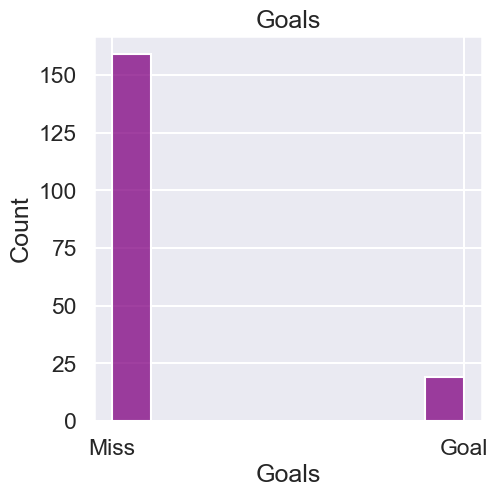

In [42]:
# Visualize ratio of goals

f, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data = cleaned_data, ax = ax, stat = 'count', multiple = 'stack',
             x = 'goal', kde = False, color = 'purple', element = 'bars', legend = False)
ax.set_title('Goals')
ax.set_xlabel('Goals')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Miss', 'Goal']);

## Feature Analysis

### Time Analysis

In [43]:
# Create a dataframe of time intervals
time_intervals_list = ['< 5', '5-15', '15-25','25-35', '35-45', '> 45']
time_intervals_df = pd.DataFrame(time_intervals_list)

# Calculate ratios each interval represents of total
time_ratios_list = []
time_ratios_list.append((round((((5 - 0) / 45) * 100), 2)))
time_ratios_list.append((round((((15 - 5) / 45) * 100), 2)))
time_ratios_list.append((round((((25 - 15) / 45) * 100), 2)))
time_ratios_list.append((round((((35 - 25) / 45) * 100), 2)))
time_ratios_list.append((round((((45 - 35) / 45) * 100), 2)))
time_ratios_list.append((round((((55 - 45) / 45) * 100), 2)))

time_ratios_df = pd.DataFrame(time_ratios_list)

# Concatenate time_intervals_df and time_ratios_df
time_interval_ratios = pd.concat([time_intervals_df,time_ratios_df],axis = 1)
time_interval_ratios.columns = ['Time Interval', 'Ratio Time']

# Calculate ratio of shots within defined time intervals
shot_time_ratios = []
shot_time_ratios.append(round(((len(cleaned_data[(cleaned_data['time'] < 5)])) / 
                               (len(cleaned_data)) * 100), 2))
shot_time_ratios.append(round(((len(cleaned_data[(cleaned_data['time'] > 5) & (cleaned_data['time'] < 15)])) / 
                               (len(cleaned_data)) * 100), 2))
shot_time_ratios.append(round(((len(cleaned_data[(cleaned_data['time'] > 15) & (cleaned_data['time'] < 25)])) / 
                               (len(cleaned_data)) * 100), 2))
shot_time_ratios.append(round(((len(cleaned_data[(cleaned_data['time'] > 25) & (cleaned_data['time'] < 35)])) / 
                               (len(cleaned_data)) * 100), 2))
shot_time_ratios.append(round(((len(cleaned_data[(cleaned_data['time'] > 35) & (cleaned_data['time'] < 45)])) / 
                               (len(cleaned_data)) * 100), 2))
shot_time_ratios.append(round(((len(cleaned_data[(cleaned_data['time'] > 45)])) / 
                               (len(cleaned_data)) * 100), 2))

# Add shot_time_ratios to time_interval_ratios
time_interval_ratios['Ratio Total Shots'] = shot_time_ratios

# Calculate ratio of goals within time intervals
goal_time_ratios = []
goal_time_ratios.append(round(((len(cleaned_data[(cleaned_data['goal'] == True) & (cleaned_data['time'] < 5)]) / 
                                len(cleaned_data[cleaned_data['goal'] == True])) * 100), 2))
goal_time_ratios.append(round(((len(cleaned_data[(cleaned_data['goal'] == True) & (cleaned_data['time'] > 5) & 
                                                 (cleaned_data['time'] < 15)]) / 
                                len(cleaned_data[cleaned_data['goal'] == True])) * 100), 2))
goal_time_ratios.append(round(((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                 (cleaned_data['time'] > 15) & (cleaned_data['time'] < 25)]) / 
                                len(cleaned_data[cleaned_data['goal'] == True])) * 100), 2))
goal_time_ratios.append(round(((len(cleaned_data[(cleaned_data['goal'] == True) & (cleaned_data['time'] > 25) 
                                                 & (cleaned_data['time'] < 35)]) / 
                                len(cleaned_data[cleaned_data['goal'] == True])) * 100), 2))
goal_time_ratios.append(round(((len(cleaned_data[(cleaned_data['goal'] == True) & (cleaned_data['time'] > 35) & 
                                                 (cleaned_data['time'] < 45)]) / 
                                len(cleaned_data[cleaned_data['goal'] == True])) * 100), 2))
goal_time_ratios.append(round(((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                 (cleaned_data['time'] > 45)]) / 
                                len(cleaned_data[cleaned_data['goal'] == True])) * 100), 2))

# Add goal_time_ratios to time_interval_ratios
time_interval_ratios['Ratio Total Goals'] = goal_time_ratios

# Calculate the ratio of shots within the interval which were a goal
goal_shot_time_ratios = []
goal_shot_time_ratios.append(round((((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                                        (cleaned_data['time'] < 5)]))/(len(cleaned_data[(cleaned_data['time'] < 5)]))) * 100), 2))
goal_shot_time_ratios.append(round((((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                                        (cleaned_data['time'] > 5) &
                                                                        (cleaned_data['time'] < 15)]))/
                                     (len(cleaned_data[(cleaned_data['time'] > 5) &
                                                                        (cleaned_data['time'] < 15)]))) *
                                    100), 2))
goal_shot_time_ratios.append(round((((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                                        (cleaned_data['time'] > 15) &
                                                                        (cleaned_data['time'] < 25)]))/
                                     (len(cleaned_data[(cleaned_data['time'] > 15) &
                                                                        (cleaned_data['time'] < 25)]))) *
                                    100), 2))
goal_shot_time_ratios.append(round((((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                                        (cleaned_data['time'] > 25) &
                                                                        (cleaned_data['time'] < 35)]))/
                                     (len(cleaned_data[(cleaned_data['time'] > 25) &
                                                                        (cleaned_data['time'] < 35)]))) *
                                    100), 2))
goal_shot_time_ratios.append(round((((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                                        (cleaned_data['time'] > 35) &
                                                                        (cleaned_data['time'] < 45)]))/
                                     (len(cleaned_data[(cleaned_data['time'] > 35) &
                                                                        (cleaned_data['time'] < 45)]))) *
                                    100), 2))
goal_shot_time_ratios.append(round((((len(cleaned_data[(cleaned_data['goal'] == True) &
                                                                        (cleaned_data['time'] > 45)]))/
                                     (len(cleaned_data[(cleaned_data['time'] > 45)]))) *
                                    100), 2))
# Add goal_shot_time_ratios to time_interval_ratios

time_interval_ratios['Ratio Goals per Capita'] = goal_shot_time_ratios

time_interval_ratios = time_interval_ratios[['Time Interval',
                                             'Ratio Time',
                                             'Ratio Total Shots',
                                             'Ratio Total Goals',
                                             'Ratio Goals per Capita']]
# Display results

time_interval_ratios


,Time Interval,Ratio Time,Ratio Total Shots,Ratio Total Goals,Ratio Goals per Capita
0,< 5,11.11,11.24,10.53,10.00
1,5-15,22.22,15.73,5.26,3.57
2,15-25,22.22,17.42,15.79,9.68
3,25-35,22.22,17.98,36.84,21.88
4,35-45,22.22,17.42,15.79,9.68
5,> 45,22.22,6.74,10.53,16.67


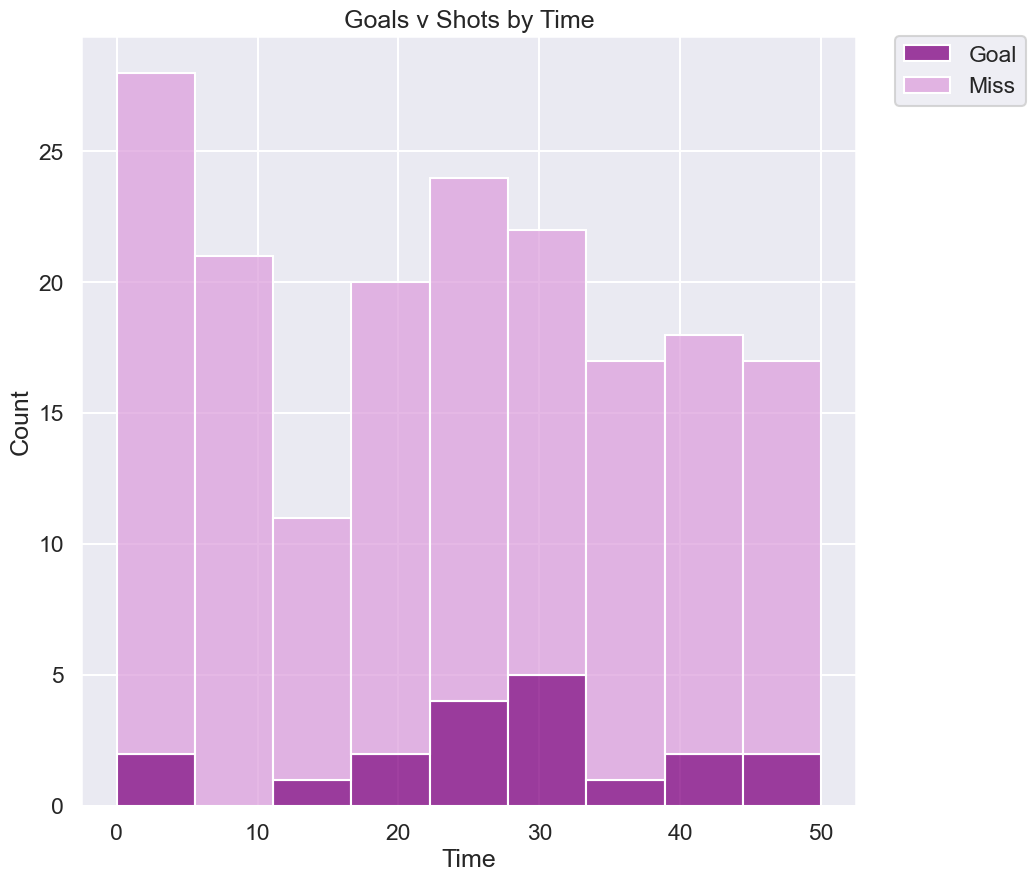

In [44]:
int_feature_v_goal('time','Time')

#### Time Findings

There does not appear to be a significant correlation between the time and the distribution of either shots or goals, nor does there appear to be a correlation between the time of the shot and the likelihood of a goal.

(Note - After 45-minutes would indicate shots during stoppage-time, which varies per match and is likely, on average, less than 10-minutes)

### Shot Distance Analysis

In [45]:
# Create a dataframe of shot distance intervals
shot_distance_intervals = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '>60']
distance_ratios = pd.DataFrame(shot_distance_intervals, columns=['Distance'])

# Calculate ratio of shots and goals in 10-yard intervals from goal_center
shot_distance_ratios = []
goal_distance_ratios = []
goal_shot_distance_ratios = []
for i in range(0, 70, 10):
    # ratio of shots
    shot_distance_count = len(cleaned_data[(cleaned_data['shot_distance'] > i) & (cleaned_data['shot_distance'] < (i + 10))])
    if shot_distance_count == 0:
        shot_ratio = 0
    else:
        shot_ratio = round((shot_distance_count / len(cleaned_data)) * 100, 2)
    shot_distance_ratios.append(shot_ratio)

    # ratio of goals
    goal_distance_count = len(cleaned_data[(cleaned_data['shot_distance'] > i) & (cleaned_data['shot_distance'] < (i + 10)) & (cleaned_data['goal'] == True)])
    if goal_distance_count == 0:
        goal_ratio = 0
    else:
        goal_ratio = round((goal_distance_count / len(cleaned_data[cleaned_data['goal'] == True])) * 100, 2)
    goal_distance_ratios.append(goal_ratio)

    # ratio of goals per capita
    if shot_distance_count == 0:
        goal_shot_ratio = 0
    else:
        goal_shot_ratio = round((goal_distance_count / shot_distance_count) * 100, 2)
    goal_shot_distance_ratios.append(goal_shot_ratio)

distance_ratios['Ratio of Total Shots'] = shot_distance_ratios
distance_ratios['Ratio of Total Goals'] = goal_distance_ratios
distance_ratios['Ratio of Goals per Capita'] = goal_shot_distance_ratios

distance_ratios


,Distance,Ratio of Total Shots,Ratio of Total Goals,Ratio of Goals per Capita
0,<10,24.16,57.89,25.58
1,10-20,41.01,31.58,8.22
2,20-30,25.84,10.53,4.35
3,30-40,7.87,0.00,0.00
4,40-50,0.56,0.00,0.00
5,50-60,0.56,0.00,0.00
6,>60,0.00,0.00,0.00


In [46]:
print('Ratio of Shots Within 30-Yards:',
      (round((len(cleaned_data[(cleaned_data['shot_distance'] < 30)]) /
              (len(cleaned_data)) * 100), 2)), '%')
print('Ratio of Goals Within 20-Yards:',
      (round((len(cleaned_data[(cleaned_data['shot_distance'] < 20) &
                               cleaned_data['goal'] == True]) /
              (len(cleaned_data[cleaned_data['goal'] == True])) * 100), 2)), '%')

Ratio of Shots Within 30-Yards: 91.01 %
Ratio of Goals Within 20-Yards: 89.47 %


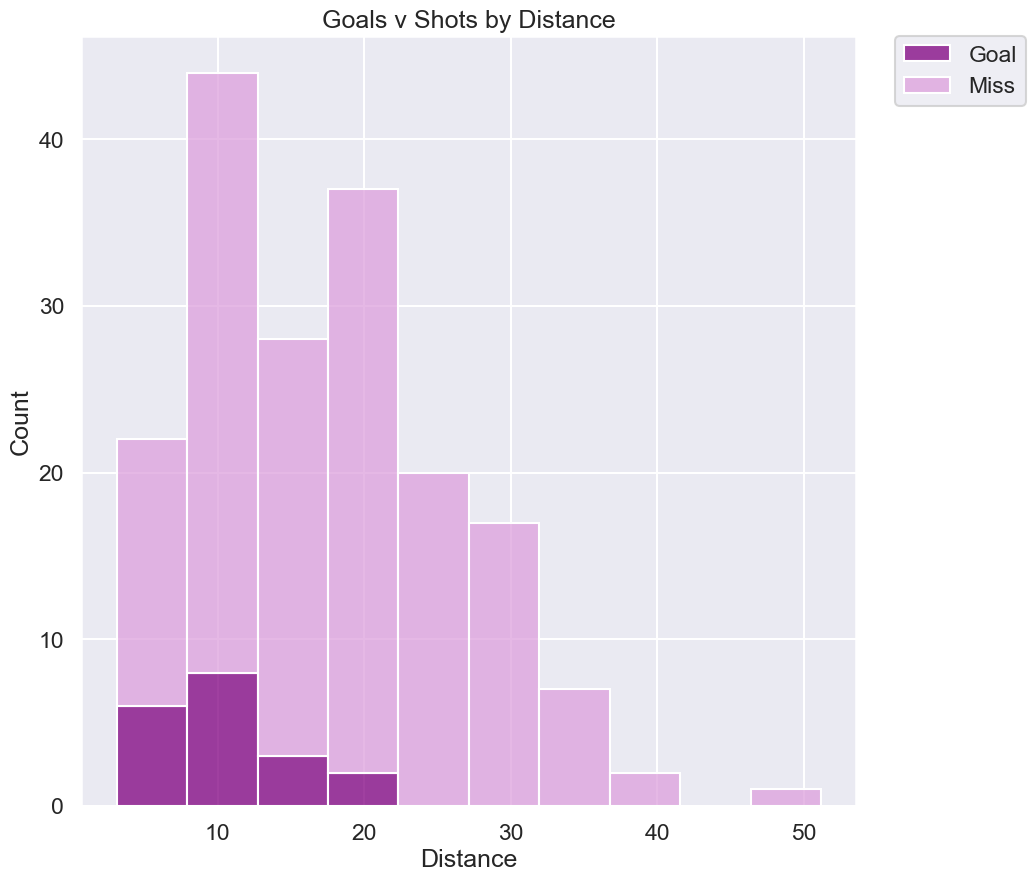

In [47]:
int_feature_v_goal('shot_distance','Distance')

#### Shot Distance Findings

The distribution of shots skews toward the 10-30-yard range, however, the distribution of goals skews closer, the 0-20-yard range.

Similarly, the ratio of goals per capita within the 0-20-yard is higher and significantly higher than the baseline goal ratio.

This indicated a correlation between shots closer to goal and an increased likelihood of scoring.

This could also indicate that players are often shooting too far from goal.

(Note - the higher ratio of goals per capita from greater-than 60-yards is likely an outlier. Very few shots have been taken from this distance, but the shots taken were likely in scenarios when scoring was relatively assured, for example if the keeper was not positioned within the goal)

### Inside Penalty Box Analysis

In [48]:
# Create a dataframe for shots inside the 18-yard-box

inside_18_list = cleaned_data['inside_18'].unique()
inside_18_ratio = pd.DataFrame(inside_18_list)

# Calculate ratio of shots and goals inside the 18-yard box

inside_18_shot_ratio = []
inside_18_goal_ratio = []
inside_18_goal_shot_ratio = []
for i in inside_18_list:
    inside_18_shot_ratio.append(round((((len(cleaned_data[cleaned_data['inside_18'] ==
                                                          i])) /
                                        (len(cleaned_data))) *
                                       100), 2))

    inside_18_goal_ratio.append(round((((len(cleaned_data[(cleaned_data['inside_18'] ==
                                                           i) &
                                                          (cleaned_data['goal'] == True)])) /
                                        (len(cleaned_data[cleaned_data['goal'] == True]))) *
                                       100), 2))

    inside_18_goal_shot_ratio.append(round((((len(cleaned_data[(cleaned_data['inside_18'] ==
                                                                i) &
                                                               (cleaned_data['goal'] == True)])) /
                                             (len(cleaned_data[cleaned_data['inside_18'] == i]))) *
                                            100), 2))

inside_18_ratio['Ratio of Total Shots'] = inside_18_shot_ratio
inside_18_ratio['Ratio of Total Goals'] = inside_18_goal_ratio
inside_18_ratio['Ratio of Goals per Capita'] = inside_18_goal_shot_ratio
inside_18_ratio.rename(columns = {inside_18_ratio.columns[0] : 'Inside 18-Yard Box' },
                            inplace = True)

inside_18_ratio

,Inside 18-Yard Box,Ratio of Total Shots,Ratio of Total Goals,Ratio of Goals per Capita
0,True,65.17,89.47,14.66
1,False,34.83,10.53,3.23


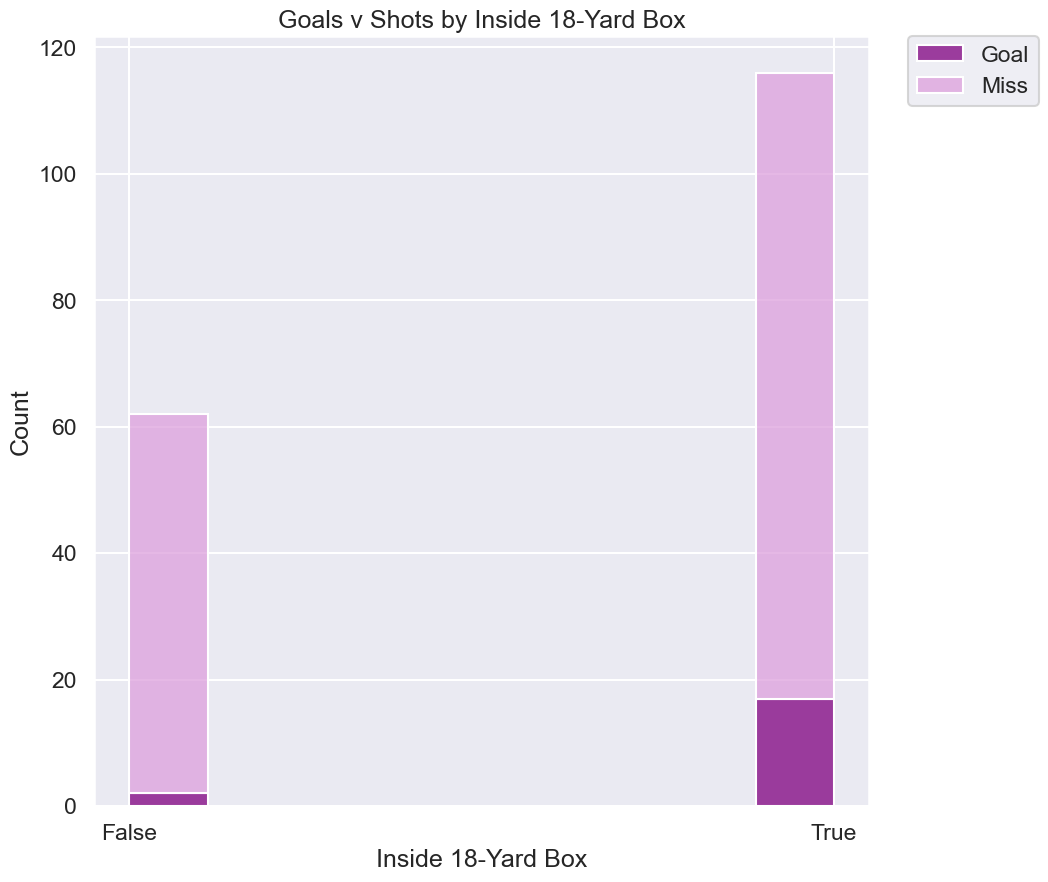

In [49]:
boolean_feature_v_goal('inside_18','Inside 18-Yard Box')

#### Inside Penalty Box Findings

The ratio of the total goals from inside the 18-yard box is significantly higher than the ratio of shots from inside the 18-yard box.

Similarly, the ratio of goals per capita inside the 18-yard box is significantly higher than the baseline goal ratio.

This indicates that shots from inside the box have a significant correlation with the likelihood of scoring.

### Shot Angle Analysis

In [50]:
cleaned_data['shot_angle'].describe()

count    178.000000
mean      92.877247
std       35.702345
min       11.660000
25%       66.085000
50%       91.395000
75%      119.352500
max      174.520000
Name: shot_angle, dtype: float64

In [51]:
shot_angle_intervals = ['<10', '10-20', '20-30', '30-40', '40-50',
                        '50-60', '60-70', '70-80', '>80']

shot_angle_ratios = pd.DataFrame(shot_angle_intervals)

shot_angle_ratios.rename(columns = {shot_angle_ratios.columns[0] : 'Angle from Center' },
                         inplace = True)

# Calculate ratio of total shots in 10-degree intervals from center

left_angle_shot_ratios = []
for i in range(90, 180, 10):
    denominator = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10))])
    if denominator == 0:
        ratio = 0
    else:
        ratio = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10))]) / len(cleaned_data) * 100
    left_angle_shot_ratios.append(round(ratio, 2))

shot_angle_ratios['Left - Ratio Total Shots'] = left_angle_shot_ratios

right_angle_ratios = []
for i in range(0, 90, 10):
    denominator = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10))])
    if denominator == 0:
        ratio = 0
    else:
        ratio = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10))]) / len(cleaned_data) * 100
    right_angle_ratios.append(round(ratio, 2))

shot_angle_ratios['Right - Ratio Total Shots'] = right_angle_ratios
shot_angle_ratios['Right - Ratio Total Shots'] = shot_angle_ratios['Right - Ratio Total Shots'].values[::-1]

# Calculate ratio of total goals in 10-degree intervals from center

left_angle_goal_ratios = []
for i in range(90, 180, 10):
    denominator = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10)) & (cleaned_data['goal'] == True)])
    if denominator == 0:
        ratio = 0
    else:
        ratio = denominator / len(cleaned_data[cleaned_data['goal'] == True]) * 100
    left_angle_goal_ratios.append(round(ratio, 2))

shot_angle_ratios['Left - Ratio Total Goals'] = left_angle_goal_ratios

right_angle_goal_ratios = []
for i in range(0, 90, 10):
    denominator = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10)) & (cleaned_data['goal'] == True)])
    if denominator == 0:
        ratio = 0
    else:
        ratio = denominator / len(cleaned_data[cleaned_data['goal'] == True]) * 100
    right_angle_goal_ratios.append(round(ratio, 2))

shot_angle_ratios['Right - Ratio Total Goals'] = right_angle_goal_ratios
shot_angle_ratios['Right - Ratio Total Goals'] = shot_angle_ratios['Right - Ratio Total Goals'].values[::-1]

# Calculate ratio of goals from shots within 10-degree intervals from center
left_angle_goal_shot_ratios = []
for i in range(90, 180, 10):
    denominator = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10))])
    if denominator == 0:
        ratio = 0
    else:
        ratio = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10)) & (cleaned_data['goal'] == True)]) / denominator * 100
    left_angle_goal_shot_ratios.append(round(ratio, 2))

shot_angle_ratios['Left - Ratio Goals per Capita'] = left_angle_goal_shot_ratios

right_angle_goal_shot_ratios = []
for i in range(0, 90, 10):
    denominator = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10))])
    if denominator == 0:
        ratio = 0
    else:
        ratio = len(cleaned_data[(cleaned_data['shot_angle'] > i) & (cleaned_data['shot_angle'] < (i + 10)) & (cleaned_data['goal'] == True)]) / denominator * 100
    right_angle_goal_shot_ratios.append(round(ratio, 2))

shot_angle_ratios['Right - Ratio Goals per Capita'] = right_angle_goal_shot_ratios
shot_angle_ratios['Right - Ratio Goals per Capita'] = shot_angle_ratios['Right - Ratio Goals per Capita'].values[::-1]

shot_angle_ratios


,Angle from Center,Left - Ratio Total Shots,Right - Ratio Total Shots,Left - Ratio Total Goals,Right - Ratio Total Goals,Left - Ratio Goals per Capita,Right - Ratio Goals per Capita
0,<10,11.24,8.43,15.79,10.53,15.00,13.33
1,10-20,7.87,7.30,5.26,5.26,7.14,7.69
2,20-30,10.11,9.55,26.32,5.26,27.78,5.88
3,30-40,6.74,6.74,0.00,5.26,0.00,8.33
4,40-50,8.99,4.49,5.26,5.26,6.25,12.50
5,50-60,4.49,4.49,0.00,10.53,0.00,25.00
6,60-70,2.25,2.25,0.00,0.00,0.00,0.00
7,70-80,1.69,1.69,0.00,0.00,0.00,0.00
8,>80,0.56,0.00,0.00,0.00,0.00,0.00


In [52]:
# Create a dataframe for shot side

side_list = ['Right',
             'Left']

side_ratio = pd.DataFrame(side_list)

side_ratio.rename(columns = {side_ratio.columns[0] : 'Side' },
                            inplace = True)

# Calculate ratio of shots and goals side

side_shot_ratio = [(round((len(cleaned_data[cleaned_data['shot_angle'] < 90]) /
                           len(cleaned_data)) * 100, 2)),
                   (round((len(cleaned_data[cleaned_data['shot_angle'] > 90]) /
                           len(cleaned_data)) * 100, 2))]

side_goal_ratio = [(round((len(cleaned_data[(cleaned_data['shot_angle'] < 90) &
                                            cleaned_data['goal'] == True]) /
                           len(cleaned_data[cleaned_data['goal'] == True])) * 100, 2)),
                   (round((len(cleaned_data[(cleaned_data['shot_angle'] > 90) &
                                            cleaned_data['goal'] == True]) /
                           len(cleaned_data[cleaned_data['goal'] == True])) * 100, 2))]

side_shot_goal_ratio = [(round(((len(cleaned_data[(cleaned_data['shot_angle'] < 90) &
                                                  (cleaned_data['goal'] == True)])) /
                                (len(cleaned_data[(cleaned_data['shot_angle'] < 90)]))) * 100, 2)),
                        (round(((len(cleaned_data[(cleaned_data['shot_angle'] > 90) &
                                                  (cleaned_data['goal'] == True)])) /
                                (len(cleaned_data[(cleaned_data['shot_angle'] > 90)]))) * 100, 2))]

side_ratio['Ratio Total Shots'] = side_shot_ratio
side_ratio['Ratio Total Goals'] = side_goal_ratio
side_ratio['Ratio Goals per Capita'] = side_shot_goal_ratio

side_ratio


,Side,Ratio Total Shots,Ratio Total Goals,Ratio Goals per Capita
0,Right,45.51,42.11,9.88
1,Left,53.93,52.63,10.42


In [53]:
print('Ratio of Total Shots within 45-Degrees from Center:',
      (round(((len(cleaned_data[(cleaned_data['shot_angle'] > 45) &
                                (cleaned_data['shot_angle'] < 135)]) /
               len(cleaned_data)) *
              100), 2)), '%')

print('Ratio of Total Goals within 45-Degrees from Center:',
      (round(((len(cleaned_data[(cleaned_data['shot_angle'] > 45) &
                                (cleaned_data['shot_angle'] < 135) &
                                (cleaned_data['goal'] == True)]) /
               len(cleaned_data[cleaned_data['goal'] == True])) *
              100), 2)), '%')

print('Ratio of Goals per Capita:',
      (round(((len(cleaned_data[(cleaned_data['shot_angle'] > 45) &
                                (cleaned_data['shot_angle'] < 135) &
                                (cleaned_data['goal'] == True)]) /
               len(cleaned_data[(cleaned_data['shot_angle'] > 45) &
                                (cleaned_data['shot_angle'] < 135)])) *
              100), 2)), '%')


Ratio of Total Shots within 45-Degrees from Center: 75.84 %
Ratio of Total Goals within 45-Degrees from Center: 84.21 %
Ratio of Goals per Capita: 11.85 %


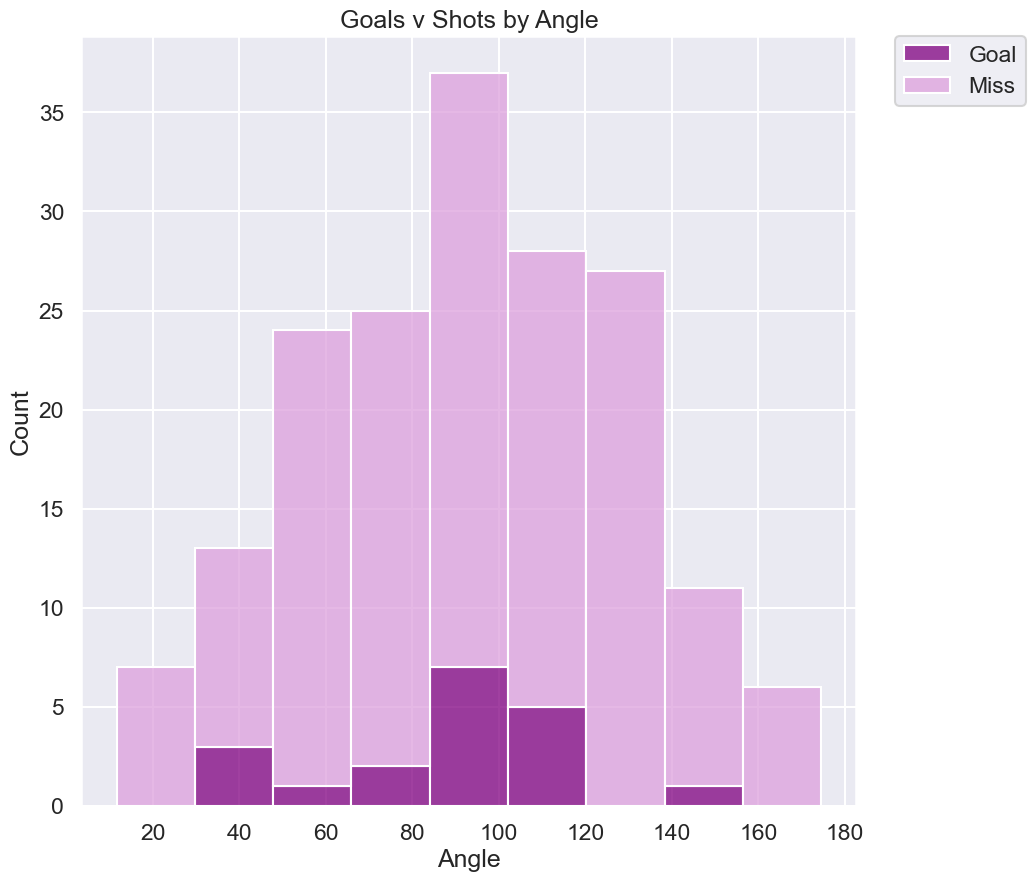

In [54]:
int_feature_v_goal('shot_angle','Angle')

#### Shot Angle Findings

The majority of shots are taken from within a 45-degree angle.

The distribution of total goals does not differ significantly from the distribution of shots.

However, the ratio of goals from shots left of center is significantly higher (this holds true at all intervals)

As a hypothesis, this is likely due to most players being right-footed:

Shooting with the inside-foot improves the body-position and flight-angle for the shot
Crosses will be more accurate, and, likely for that reason, more frequent, with the outside-foot and crosses are typically aimed to travel across the face of goal and are then finished on the opposite side

### Body Part Analysis

In [55]:
display(cleaned_data['bodypart'].value_counts(dropna = False))

Right Foot    102
Left Foot      45
Head           30
Other           1
Name: bodypart, dtype: int64

In [56]:
# Create a dataframe of shot angle intervals

bodypart_list = ['Right Foot',
                  'Left Foot',
                  'Head']

bodypart_ratio = pd.DataFrame(bodypart_list)

bodypart_ratio.rename(columns = {bodypart_ratio.columns[0] : 'Bodypart' },
                            inplace = True)

# Calculate ratio of shots and goals by bodypart

bodypart_shot_ratio = []
bodypart_goal_ratio = []
bodypart_goal_shot_ratio = []
for i in bodypart_list:
    bodypart_shot_ratio.append(round((((len(cleaned_data[cleaned_data['bodypart'] ==
                                                         i])) /
                                       (len(cleaned_data))) *
                                      100), 2))

    bodypart_goal_ratio.append(round((((len(cleaned_data[(cleaned_data['bodypart'] ==
                                                          i) &
                                                         (cleaned_data['goal'] == True)])) /
                                       (len(cleaned_data[cleaned_data['goal'] == True]))) *
                                      100), 2))

    bodypart_goal_shot_ratio.append(round((((len(cleaned_data[(cleaned_data['bodypart'] ==
                                                               i) &
                                                              (cleaned_data['goal'] == True)])) /
                                            (len(cleaned_data[cleaned_data['bodypart'] ==
                                                              i]))) *
                                           100), 2))

bodypart_ratio['Ratio of Total Shots'] = bodypart_shot_ratio
bodypart_ratio['Ratio of Total Goals'] = bodypart_goal_ratio
bodypart_ratio['Ratio of Goals per Capita'] = bodypart_goal_shot_ratio

bodypart_ratio


,Bodypart,Ratio of Total Shots,Ratio of Total Goals,Ratio of Goals per Capita
0,Right Foot,57.30,47.37,8.82
1,Left Foot,25.28,26.32,11.11
2,Head,16.85,26.32,16.67


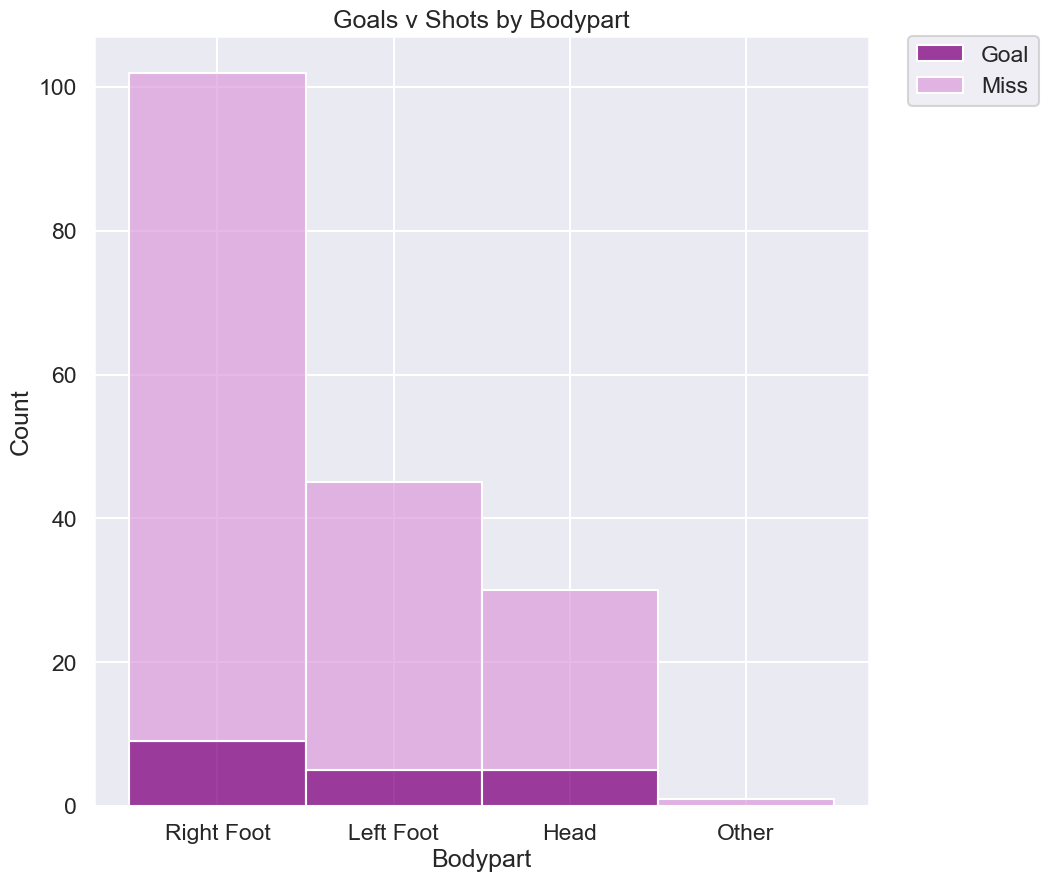

In [57]:
category_feature_v_goal('bodypart','Bodypart')

#### Body Part Findings

As expected, the majority of shots are with the right-foot.

The distribution of goals per bodypart does not differ significantly from the ratio of shots.

The ratio of goals per capita does not differ significantly from the baseline goal ratio.

### Technique Analysis

In [58]:
cleaned_data['technique'].value_counts(dropna = False)

Ground    141
Volley     37
Name: technique, dtype: int64

In [59]:
# Create a dataframe of shot angle intervals

technique_list = cleaned_data['technique'].unique()

technique_ratio = pd.DataFrame(technique_list)

technique_ratio.rename(columns = {technique_ratio.columns[0] : 'Technique' },
                            inplace = True)

# Calculate ratio of shots and goals by technique

technique_shot_ratio = []
technique_goal_ratio = []
technique_goal_shot_ratio = []
for i in technique_list:
    technique_shot_ratio.append(round((((len(cleaned_data[cleaned_data['technique'] ==
                                                          i])) /
                                        (len(cleaned_data))) *
                                       100), 2))

    technique_goal_ratio.append(round((((len(cleaned_data[(cleaned_data['technique'] ==
                                                           i) &
                                                          (cleaned_data['goal'] == True)])) /
                                        (len(cleaned_data[cleaned_data['goal'] == True]))) *
                                       100), 2))

    technique_goal_shot_ratio.append(round((((len(cleaned_data[(cleaned_data['technique'] ==
                                                                i) &
                                                               (cleaned_data['goal'] == True)])) /
                                             (len(cleaned_data[cleaned_data['technique'] == i]))) *
                                            100), 2))

technique_ratio['Ratio Total Shots'] = technique_shot_ratio
technique_ratio['Ratio Total Goals'] = technique_goal_ratio
technique_ratio['Ratio Goal per Capita'] = technique_goal_shot_ratio

technique_ratio


,Technique,Ratio Total Shots,Ratio Total Goals,Ratio Goal per Capita
0,Volley,20.79,26.32,13.51
1,Ground,79.21,73.68,9.93


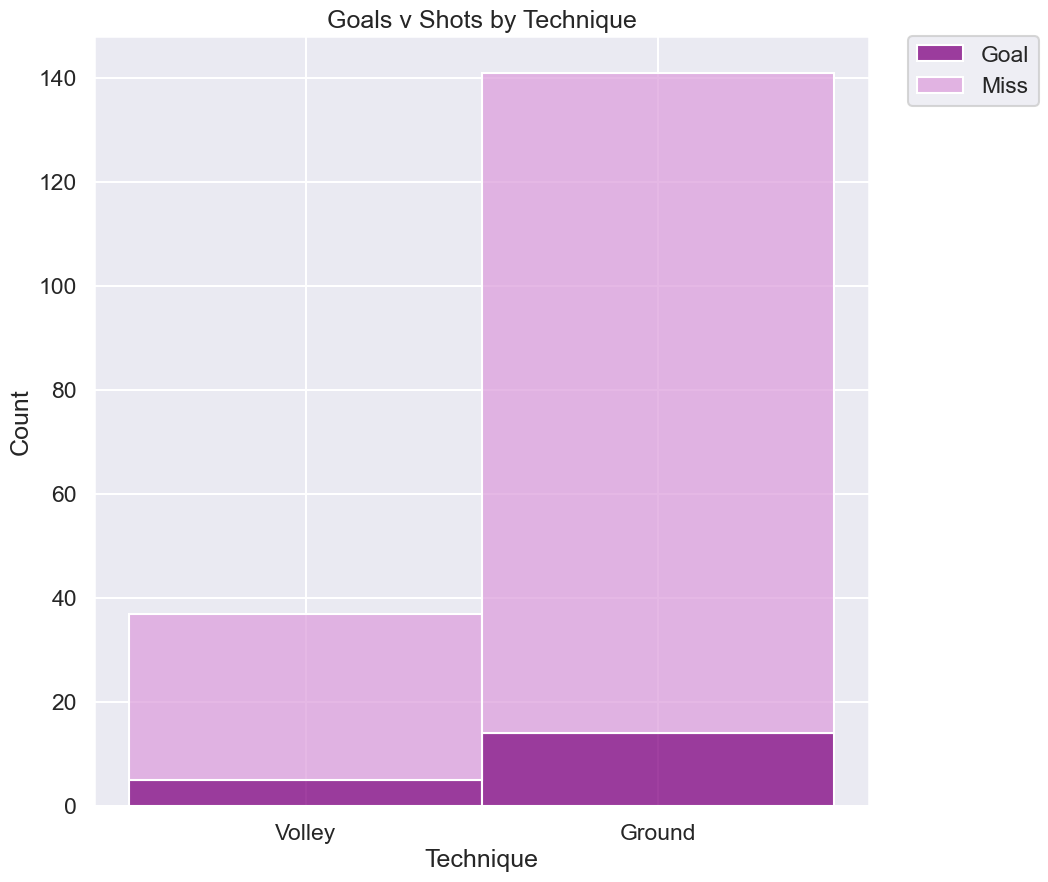

In [60]:
category_feature_v_goal('technique','Technique')

#### Technique Findings

As expected, the majority of shots are from the ground.

The ratio of goals per technique does not differ significantly from the ratio of shots.

The ratio of goals per capita does not differ significantly from the baseline goal ratio.

### First Touch Analysis

In [61]:
# Create a dataframe of shot angle intervals

first_touch_list = cleaned_data['first_touch'].unique()

first_touch_ratio = pd.DataFrame(first_touch_list)

first_touch_ratio.rename(columns = {first_touch_ratio.columns[0] : 'First Touch' },
                            inplace = True)

# Calculate ratio of shots and goals by first touch

first_touch_shot_ratio = []
first_touch_goal_ratio = []
first_touch_goal_shot_ratio = []
for i in first_touch_list:
    first_touch_shot_ratio.append(round((((len(cleaned_data[cleaned_data['first_touch'] ==
                                                            i])) /
                                          (len(cleaned_data))) *
                                         100), 2))

    first_touch_goal_ratio.append(round((((len(cleaned_data[(cleaned_data['first_touch'] ==
                                                             i) &
                                                            (cleaned_data['goal'] == True)])) /
                                          (len(cleaned_data[cleaned_data['goal'] == True]))) *
                                         100), 2))

    first_touch_goal_shot_ratio.append(round((((len(cleaned_data[(cleaned_data['first_touch'] ==
                                                                  i) &
                                                                 (cleaned_data['goal'] == True)])) /
                                               (len(cleaned_data[cleaned_data['first_touch'] == i]))) *
                                              100), 2))

first_touch_ratio['Ratio Total Shots'] = first_touch_shot_ratio
first_touch_ratio['Ratio Total Goal'] = first_touch_goal_ratio
first_touch_ratio['Ratio Goals per Capita'] = first_touch_goal_shot_ratio

first_touch_ratio


,First Touch,Ratio Total Shots,Ratio Total Goal,Ratio Goals per Capita
0,True,31.46,57.89,19.64
1,False,68.54,42.11,6.56


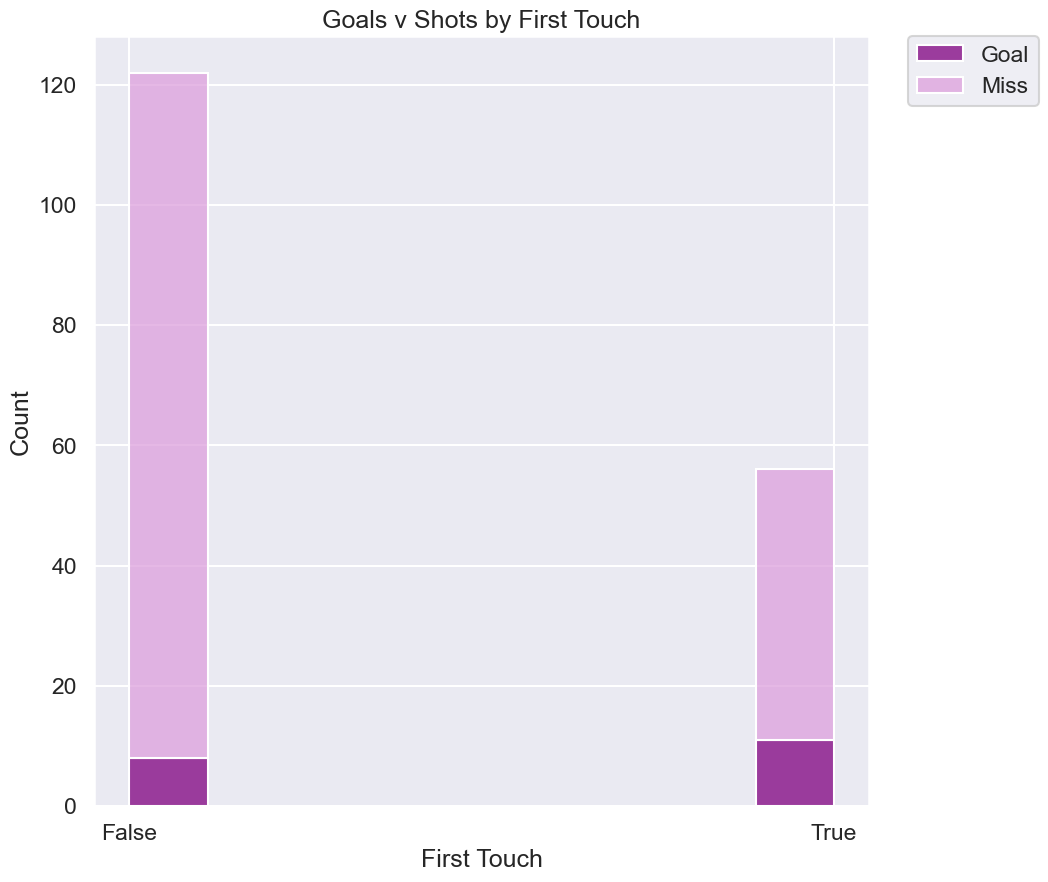

In [62]:
boolean_feature_v_goal('first_touch','First Touch')

#### First Touch Findings

As expected, the majority of shots are not with the first-touch.

A slightly higher ratio of shots with the first-touch result in a goal.

### Assist Analysis

In [63]:
# Create a dataframe of shot angle intervals

assist_list = cleaned_data['assist'].unique()
assist_ratio = pd.DataFrame(assist_list)
assist_ratio.rename(columns = {assist_ratio.columns[0] : 'Assist' },
                    inplace = True)

# Calculate ratio of shots and goals by assist type

assist_shot_ratio = []
assist_goal_ratio = []
assist_goal_shot_ratio = []
for i in assist_list:
    assist_shot_ratio.append(round((((len(cleaned_data[cleaned_data['assist'] ==
                                                       i])) /
                                     (len(cleaned_data))) *
                                    100), 2))

    assist_goal_ratio.append(round((((len(cleaned_data[(cleaned_data['assist'] ==
                                                        i) &
                                                       (cleaned_data['goal'] == True)])) /
                                     (len(cleaned_data[cleaned_data['goal'] == True]))) *
                                    100), 2))

    assist_goal_shot_ratio.append(round((((len(cleaned_data[(cleaned_data['assist'] ==
                                                             i) &
                                                            (cleaned_data['goal'] == True)])) /
                                          (len(cleaned_data[cleaned_data['assist'] == i]))) *
                                         100), 2))

assist_ratio['Ratio Total Shots'] = assist_shot_ratio
assist_ratio['Ratio Total Goals'] = assist_goal_ratio
assist_ratio['Ratio Goals per Capita'] = assist_goal_shot_ratio

assist_ratio


,Assist,Ratio Total Shots,Ratio Total Goals,Ratio Goals per Capita
0,Low Pass,7.30,10.53,15.38
1,High Pass,26.40,21.05,8.51
2,Ground Pass,33.15,21.05,6.78
3,Unassisted,33.15,47.37,15.25


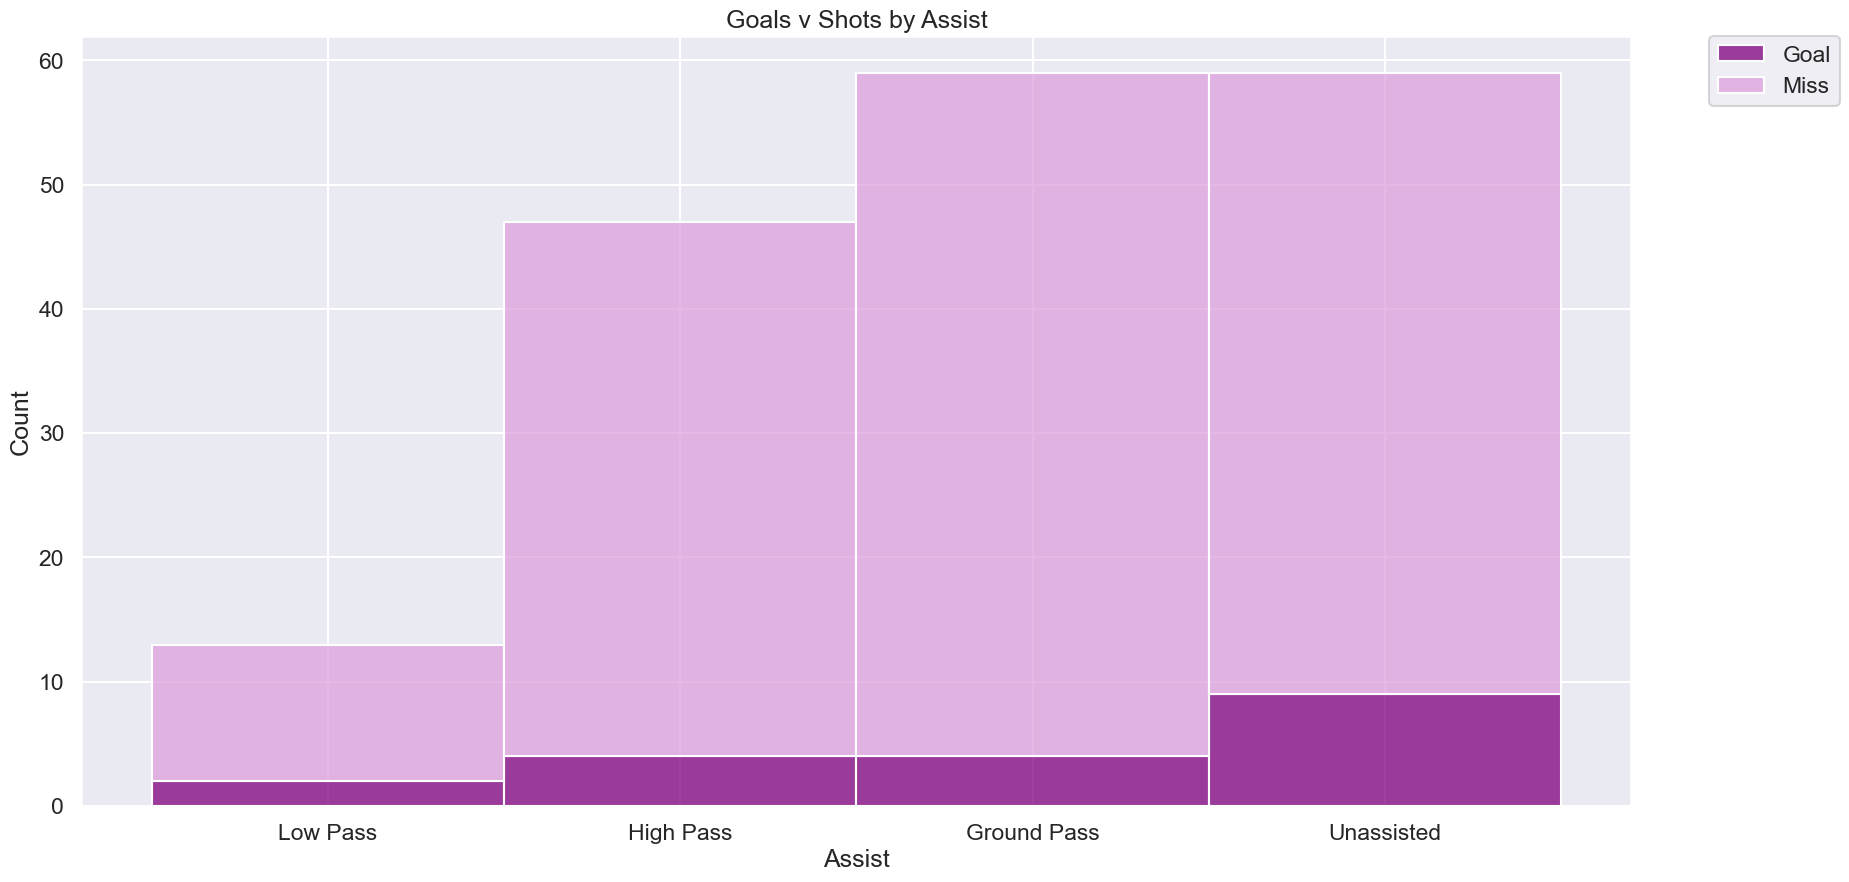

In [64]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_palette(sns.color_palette(['plum', 'purple']))
sns.histplot(data = cleaned_data,
             ax = ax,
             multiple = 'stack',
             x = 'assist',
             hue = 'goal',
             element = 'bars')
ax.set_title('Goals v Shots by Assist')
ax.set_xlabel('Assist')
ax.legend(labels = ['Goal',
                    'Miss'],
          bbox_to_anchor = (1.05, 1),
          loc = 2,
          borderaxespad = 0);

#### Assist Findings

Unassisted accounts for the largest ratio of shots and a similar ratio of goals, but the ratio of goals per capita does not differ significantly from the baseline.

Ground Passes account for a significant ratio of shots, however, has a signigicantly lower ratio of goals per capita, significantly lower than the baseline goal ratio.

Crosses account for a higher ratio of shots and also a higher ratio of goals per capita, higher than the baseline goal ratio. This indicates a correlation between crosses and the likelihood of scoring.

Through-balls account for a lower ratio of shots, however, has the highest ratio of goals per capita, significantly higher than the baseline goal ratio.

### State of Play Analysis

In [65]:
# Create a dataframe of shot angle intervals

state_of_play_list = cleaned_data['state_of_play'].unique()
state_of_play_ratio = pd.DataFrame(state_of_play_list)
state_of_play_ratio.rename(columns = {state_of_play_ratio.columns[0] : 'State of Play' },
                    inplace = True)

# Calculate ratio of shots and goals by state of play

state_of_play_shot_ratio = []
state_of_play_goal_ratio = []
state_of_play_goal_shot_ratio = []
for i in state_of_play_list:
    state_of_play_shot_ratio.append(round((((len(cleaned_data[cleaned_data['state_of_play'] ==
                                                              i])) /
                                            (len(cleaned_data))) *
                                           100), 2))

    state_of_play_goal_ratio.append(round((((len(cleaned_data[(cleaned_data['state_of_play'] ==
                                                               i) &
                                                              (cleaned_data['goal'] == True)])) /
                                            (len(cleaned_data[cleaned_data['goal'] == True]))) *
                                           100), 2))

    state_of_play_goal_shot_ratio.append(round((((len(cleaned_data[(cleaned_data['state_of_play'] ==
                                                                    i) &
                                                                   (cleaned_data['goal'] == True)])) /
                                                 (len(cleaned_data[cleaned_data['state_of_play'] == i]))) *
                                                100), 2))

state_of_play_ratio['Ratio Total Shots'] = state_of_play_shot_ratio
state_of_play_ratio['Ratio Total Goals'] = state_of_play_goal_ratio
state_of_play_ratio['Ratio Goals per Capita'] = state_of_play_goal_shot_ratio

state_of_play_ratio

,State of Play,Ratio Total Shots,Ratio Total Goals,Ratio Goals per Capita
0,Open Play - Shot,98.31,94.74,10.29
1,Set Piece - Penalty,1.12,5.26,50.00
2,Set Piece - Direct Free Kick,0.56,0.00,0.00


In [66]:
# Create a dataframe for Open Play v Set Piece

ovs_list = ['Open Play',
            'Set Piece']

ovs_ratio = pd.DataFrame(ovs_list)

ovs_ratio.rename(columns = {ovs_ratio.columns[0] : 'State of Play' },
                    inplace = True)

# Calculate ratio of shots and goals for Open Play v Set Piece

ovs_shot_ratio = []
ovs_goal_ratio = []
ovs_goal_shot_ratio = []
for i in ovs_list:
    ovs_shot_ratio.append(round((((len(cleaned_data[cleaned_data['state_of_play'].str.contains(i)])) /
                                  (len(cleaned_data))) * 100), 2))

    ovs_goal_ratio.append(round((((len(cleaned_data[(cleaned_data['state_of_play'].str.contains(i)) &
                                                    (cleaned_data['goal'] == True)])) /
                                  (len(cleaned_data[cleaned_data['goal'] == True]))) *
                                 100), 2))
    ovs_goal_shot_ratio.append(round((((len(cleaned_data[(cleaned_data['state_of_play'].str.contains(i)) &
                                                         (cleaned_data['goal'] == True)])) /
                                       (len(cleaned_data[cleaned_data['state_of_play'].str.contains(i)]))) *
                                      100), 2))

ovs_ratio['Ratio Total Shots'] = ovs_shot_ratio
ovs_ratio['Ratio Total Goals'] = ovs_goal_ratio
ovs_ratio['Ratio Goals per Capita'] = ovs_goal_shot_ratio

ovs_ratio


,State of Play,Ratio Total Shots,Ratio Total Goals,Ratio Goals per Capita
0,Open Play,98.31,94.74,10.29
1,Set Piece,1.69,5.26,33.33


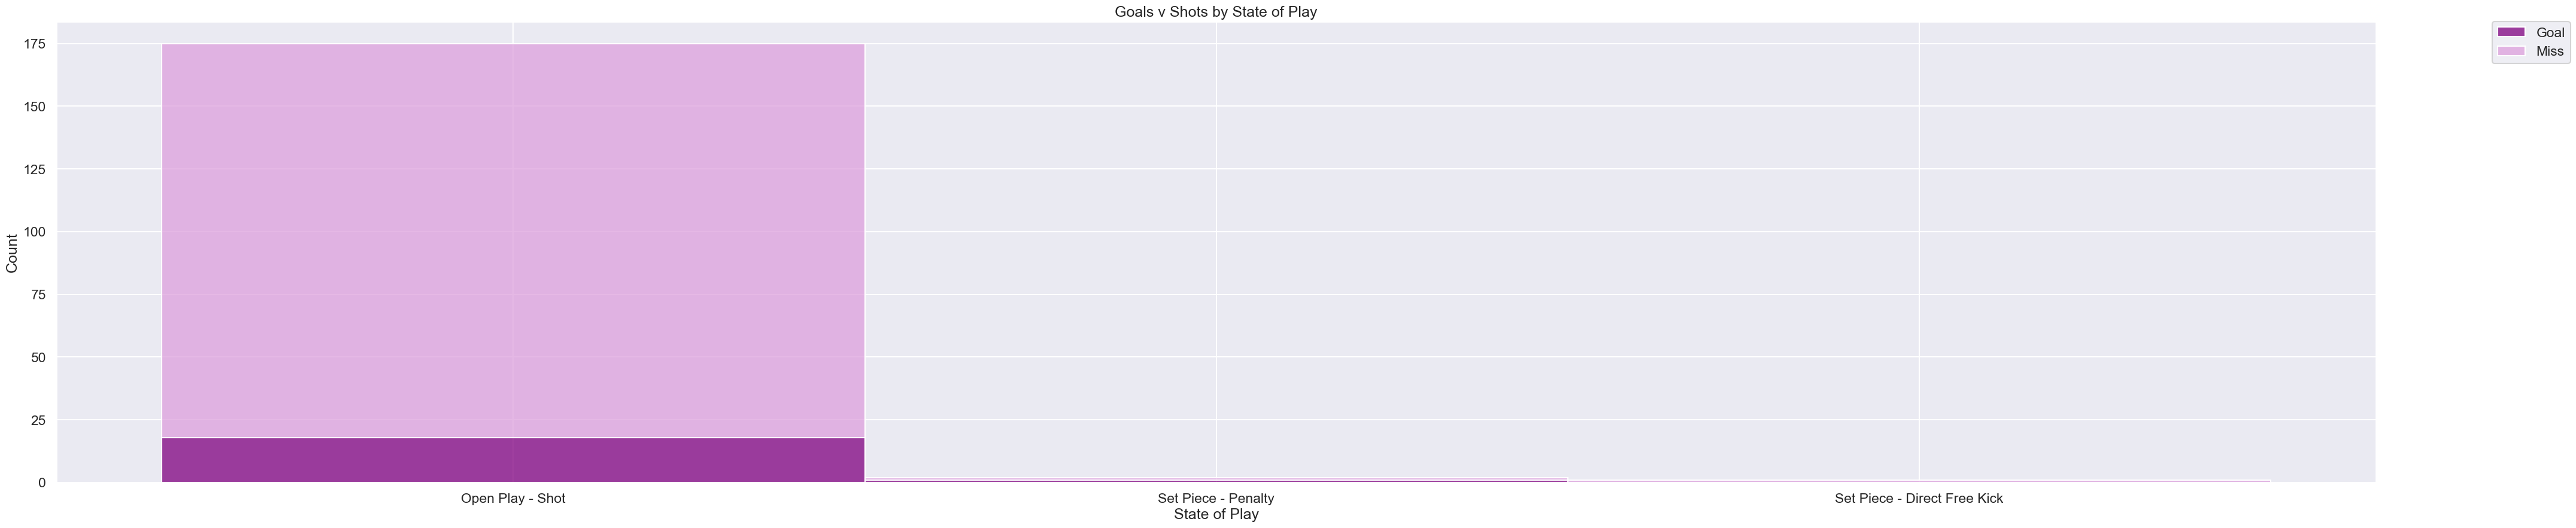

In [67]:
f, ax = plt.subplots(figsize=(50, 10))
sns.set_palette(sns.color_palette(['plum', 'purple']))
sns.histplot(data = cleaned_data,
             ax = ax,
             multiple = 'stack',
             x = 'state_of_play',
             hue = 'goal',
             element = 'bars')
ax.set_title('Goals v Shots by State of Play')
ax.set_xlabel('State of Play')
ax.legend(labels = ['Goal',
                    'Miss'],
          bbox_to_anchor = (1.05, 1),
          loc = 2,
          borderaxespad = 0);

#### State of Play Findings

Not relevant

# Part 6: Data Preprocessing

In [68]:
# Drop unique variables, 'player' and 'team'
# Drop statsbomb_xg as modeling will generate new xG

cleaned_data.drop(['statsbomb_xg',
                   'player',
                   'team'],
                  axis = 1,
                  inplace = True)

In [69]:
# Separate Target Variable
y = cleaned_data['goal']
X = cleaned_data.drop('goal',
                      axis = 1)
y = pd.DataFrame(y)

In [70]:
# Split data in train and test

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 13)

In [71]:
# Label Encode Target Variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Convert encoded target variables to dataframe
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [72]:
# Label Encode Boolean Variables
boolean_variables = ['inside_18', 'first_touch']

# Label encode boolean variables
le_train = X_train[boolean_variables]
le_test = X_test[boolean_variables]
le_X = X[boolean_variables]

for i in boolean_variables:
    le_train[i] = le.fit_transform(le_train[i])
    le_test[i] = le.transform(le_test[i])
    le_X[i] = le.transform(le_X[i])

le_train = pd.DataFrame(le_train)
le_test = pd.DataFrame(le_test)
le_X = pd.DataFrame(le_X)

In [73]:
# One Hot Encode Categorical Variables
categorical_variables = ['bodypart',
                         'technique',
                         'assist',
                         'state_of_play']
ohe = OneHotEncoder(categories='auto',
                    handle_unknown='ignore')

# Initialize empty dataframes for one-hot encoded features
ohe_train = pd.DataFrame()
ohe_test = pd.DataFrame()
ohe_X = pd.DataFrame()

for i in categorical_variables:
    # Fit the OneHotEncoder on the training data
    ohe_train_features = ohe.fit_transform(X_train[[i]]).toarray()
    ohe_train_labels = ohe.get_feature_names_out([i])
    ohe_train_i = pd.DataFrame(ohe_train_features, columns=ohe_train_labels, index=X_train.index)

    # Transform the test data using the fitted OneHotEncoder
    ohe_test_features = ohe.transform(X_test[[i]]).toarray()
    ohe_test_labels = ohe.get_feature_names_out([i])
    ohe_test_i = pd.DataFrame(ohe_test_features, columns=ohe_test_labels, index=X_test.index)

    # Transform the entire dataset using the fitted OneHotEncoder
    ohe_X_features = ohe.transform(X[[i]]).toarray()
    ohe_X_labels = ohe.get_feature_names_out([i])
    ohe_X_i = pd.DataFrame(ohe_X_features, columns=ohe_X_labels, index=X.index)

    # Concatenate one-hot encoded features to their respective dataframes
    ohe_train = pd.concat([ohe_train, ohe_train_i], axis=1)
    ohe_test = pd.concat([ohe_test, ohe_test_i], axis=1)
    ohe_X = pd.concat([ohe_X, ohe_X_i], axis=1)


In [74]:
# Scale Numerical Variables

numerical_variables = ['time','shot_distance','shot_angle']
ss = StandardScaler()
ct = ColumnTransformer([('ss', ss, numerical_variables)])

# Scale numerical variables
ss_train = ct.fit_transform(X_train)
ss_test = ct.transform(X_test)
ss_X = ct.transform(X)

ss_train = pd.DataFrame(ss_train,
                        columns = numerical_variables)
ss_test = pd.DataFrame(ss_test,
                        columns = numerical_variables)
ss_X = pd.DataFrame(ss_X,
                    columns = numerical_variables)

In [75]:
# Create New Dataframe from Preprocessed Data

le_train.reset_index(drop = True,inplace = True)
ohe_train.reset_index(drop = True,inplace = True)
ss_train.reset_index(drop = True,inplace = True)

le_test.reset_index(drop = True,inplace = True)
ohe_test.reset_index(drop = True,inplace = True)
ss_test.reset_index(drop = True,inplace = True)

le_X.reset_index(drop = True,inplace = True)
ohe_X.reset_index(drop = True,inplace = True)
ss_X.reset_index(drop = True,inplace = True)

X_train = pd.concat([le_train, ohe_train, ss_train],axis = 1)

X_test = pd.concat([le_test, ohe_test, ss_test],axis = 1)

X = pd.concat([le_X, ohe_X, ss_X],axis = 1)

In [76]:
# Save Everything to CSV

X_train.to_csv('./final_statsbomb_data/data_preprocessing/X_train.csv')
X_test.to_csv('./final_statsbomb_data/data_preprocessing/X_test.csv')
X.to_csv('./final_statsbomb_data/data_preprocessing/X.csv')

y_train.to_csv('./final_statsbomb_data/data_preprocessing/y_train.csv')
y_test.to_csv('./final_statsbomb_data/data_preprocessing/y_test.csv')
y.to_csv('./final_statsbomb_data/data_preprocessing/y.csv') 

# Part 7: Model Fitting

## Class Imbalance

Use Synthetic Minority Oversampling Technique to address class imbalance because the priority is identifying true-positives, and true-positives are the minority class, SMOTE oversamples true-positives, generating synthetic samples to help avoid overfitting during the modeling process by balancing the classes.


In [77]:
sm = SMOTE(random_state = 13)
oversample_X_train, oversample_y_train = sm.fit_resample(X_train, y_train)

X_train_os = pd.DataFrame(oversample_X_train,columns = X_train.columns)
y_train_os = pd.DataFrame(oversample_y_train,columns = y_train.columns)

X_train_os.to_csv('./final_statsbomb_data/data_modeling/X_train_os.csv')
y_train_os.to_csv('./final_statsbomb_data/data_modeling/y_train_os.csv')

In [78]:
# Use Grid Search to find the best parameters for model
def model_grid(model, params):
    grid = GridSearchCV(model,
                        params,
                        refit = True,
                        cv = 5)
    
    grid.fit(X_train_os, y_train_os)

    grid_best = grid.best_params_

    display(grid_best)
    
# Generate model report
def model_report(train, train_prediction):
    report = pd.DataFrame(classification_report(train,
                                              train_prediction,
                                              output_dict = True))
    display(report)
    
# Calculate model ROC AUC, Visualize ROC Curve
def model_roc(train,test,train_probability,test_probability):
    print('Train - Area Under the Curve:',
        round(roc_auc_score(train,
                            train_probability[:,1]),2))
    print('Test - Area Under the Curve:',
        round(roc_auc_score(test,
                            test_probability[:,1]),2))

    fpr_train, tpr_train, thresholds_train = roc_curve(train, 
                                                     train_probability[:,1])
    fpr_test, tpr_test, thresholds_test = roc_curve(test, 
                                                     test_probability[:,1])

    f, ax = plt.subplots(figsize = (10, 10))

    plt.plot(fpr_train,
           tpr_train,
           'aqua',
           label = 'Train')

    plt.plot(fpr_test,
           tpr_test,
           'lightcoral',
           label = 'Test')

    plt.plot([0, 1],
           [0, 1],
           'purple')

    ax.set_title('Receiver Operating Characteristic')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(bbox_to_anchor = (1.05, 1),loc = 2,borderaxespad = 0);


## Evaluation Metrics

The following metrics are being calculated for each of the models tested (in order of value):

Recall - Ratio of true positives, shots correctly identified as goals
ROC - Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC); True Positive Rate (TPR) v False Positive Rate (FPR) plotted and the area under the curve of the plot measured
Accuracy - Ratio of shots correctly identified

## Models

In [79]:
# Logistic Regression

lr = LogisticRegression(random_state = 13, class_weight = 'balanced')

lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

model_grid(lr, lr_params)

lr_best = LogisticRegression(random_state = 13, C = 10, class_weight = 'balanced', solver = 'sag')

lr_best.fit(X_train_os, y_train_os)

lr_train_predict = lr_best.predict(X_train_os)
lr_train_probability = lr_best.predict_proba(X_train_os)

lr_test_predict = lr_best.predict(X_test)
lr_test_probability = lr_best.predict_proba(X_test)

print('Train Report')
model_report(y_train_os,lr_train_predict)

print('Test Report')
model_report(y_test,lr_test_predict)

{'C': 1, 'solver': 'newton-cg'}

Train Report


,0,1,accuracy,macro avg,weighted avg
precision,0.815126,0.777778,0.795276,0.796452,0.796452
recall,0.763780,0.826772,0.795276,0.795276,0.795276
f1-score,0.788618,0.801527,0.795276,0.795072,0.795072
support,127.000000,127.000000,0.795276,254.000000,254.000000


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.931034,0.285714,0.805556,0.608374,0.859332
recall,0.843750,0.500000,0.805556,0.671875,0.805556
f1-score,0.885246,0.363636,0.805556,0.624441,0.827289
support,32.000000,4.000000,0.805556,36.000000,36.000000


Train - Area Under the Curve: 0.88
Test - Area Under the Curve: 0.73


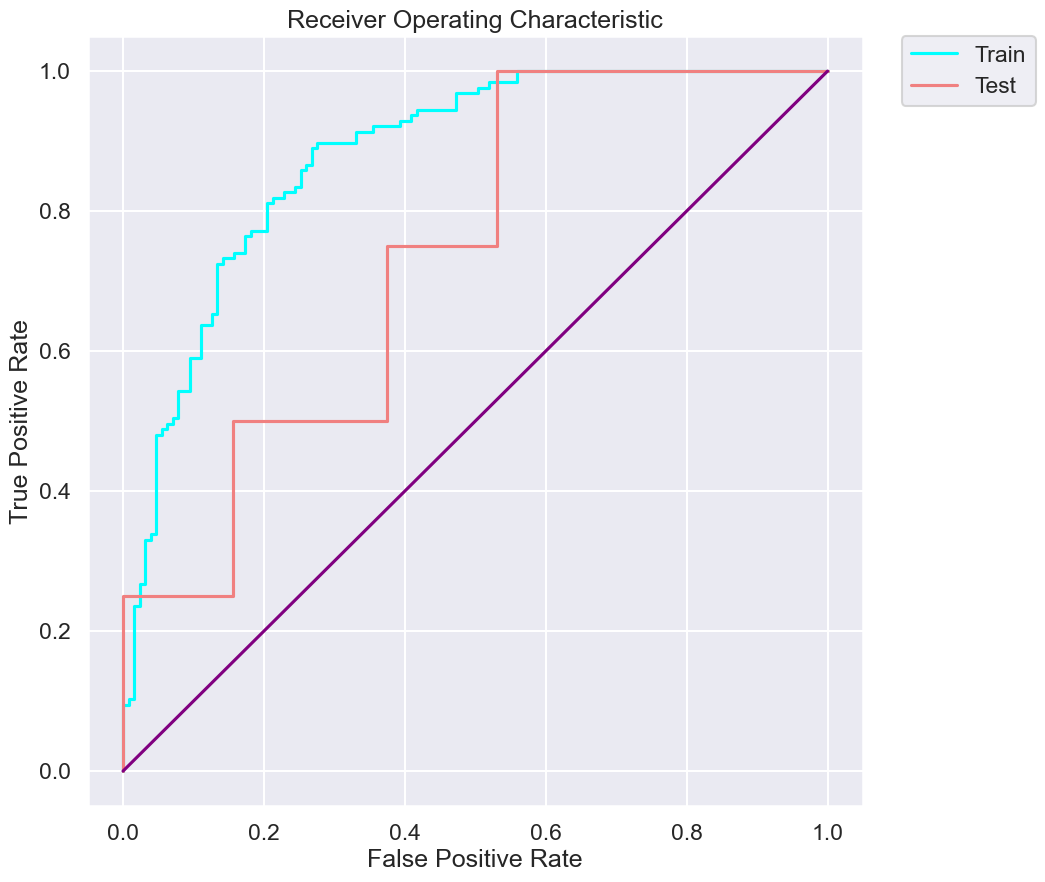

In [80]:
model_roc(y_train_os, y_test, lr_train_probability, lr_test_probability)

In [81]:
# save model
pickle.dump(lr_best, open('./final_statsbomb_data/data_modeling/lr.pkl','wb'))

In [82]:
# K Neighbors

kn = KNeighborsClassifier()

kn_params = {'metric': ['euclidean', 'manhattan'],
             'leaf_size' : [1, 10, 20, 30, 40, 50],
             'weights' : ['uniform', 'distance'],
             'n_neighbors' : [1, 10, 20, 30],
             'p' : [1, 2]}

# Use Grid Search to find the best parameters for kn
model_grid(kn, kn_params)

# Refine kn parameters for Grid Search
kn_best = KNeighborsClassifier(metric = 'manhattan', p = 1, weights = 'uniform')
kn_params = {'leaf_size' : [1, 5],'n_neighbors' : [1, 5]}
model_grid(kn_best, kn_params)

# Define best paramters for kn
kn_best = KNeighborsClassifier(metric = 'manhattan',leaf_size = 1,p = 1,weights = 'uniform',n_neighbors = 1)

kn_best.fit(X_train_os, y_train_os)

kn_train_predict = kn_best.predict(X_train_os)
kn_train_probability = kn_best.predict_proba(X_train_os)

kn_test_predict = kn_best.predict(X_test)
kn_test_probability = kn_best.predict_proba(X_test)

print('Train Report')
model_report(y_train_os,kn_train_predict)

print('Test Report')
model_report(y_test,kn_test_predict)

{'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 1,
 'p': 1,
 'weights': 'uniform'}

{'leaf_size': 1, 'n_neighbors': 1}

Train Report


,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,127.0,127.0,1.0,254.0,254.0


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.90625,0.25,0.833333,0.578125,0.833333
recall,0.90625,0.25,0.833333,0.578125,0.833333
f1-score,0.90625,0.25,0.833333,0.578125,0.833333
support,32.00000,4.00,0.833333,36.000000,36.000000


In [83]:
# Need to make adjustments due to signs of overfitting

kn_best = KNeighborsClassifier(metric = 'manhattan',leaf_size = 1,p = 1,weights = 'uniform', n_neighbors = 20)

kn_best.fit(X_train_os,y_train_os)

kn_train_predict = kn_best.predict(X_train_os)
kn_train_probability = kn_best.predict_proba(X_train_os)

kn_test_predict = kn_best.predict(X_test)
kn_test_probability = kn_best.predict_proba(X_test)

print('Train Report')
model_report(y_train_os, kn_train_predict)

print('Test Report')
model_report(y_test, kn_test_predict)

Train Report


,0,1,accuracy,macro avg,weighted avg
precision,0.955056,0.745455,0.818898,0.850255,0.850255
recall,0.669291,0.968504,0.818898,0.818898,0.818898
f1-score,0.787037,0.842466,0.818898,0.814751,0.814751
support,127.000000,127.000000,0.818898,254.000000,254.000000


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.892857,0.125000,0.722222,0.508929,0.807540
recall,0.781250,0.250000,0.722222,0.515625,0.722222
f1-score,0.833333,0.166667,0.722222,0.500000,0.759259
support,32.000000,4.000000,0.722222,36.000000,36.000000


Train - Area Under the Curve: 0.94
Test - Area Under the Curve: 0.72


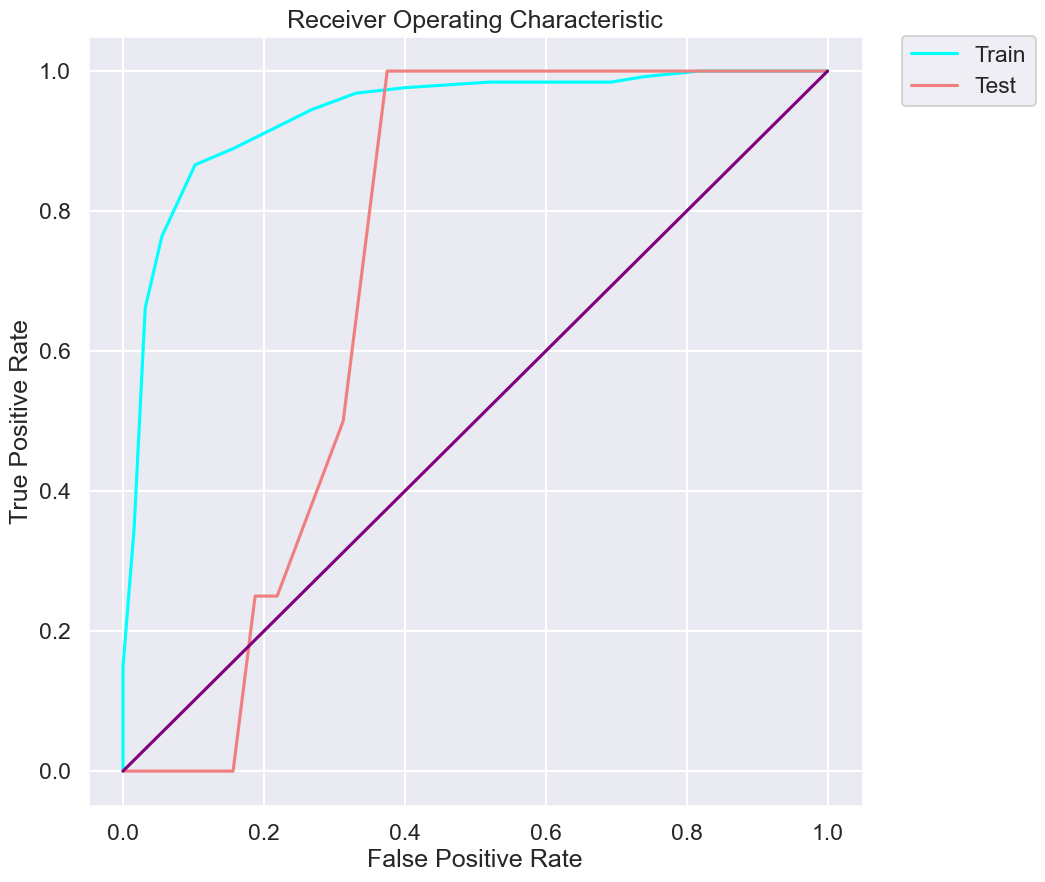

In [84]:
model_roc(y_train_os,y_test,kn_train_probability,kn_test_probability)

In [85]:
pickle.dump(kn_best, open('./final_statsbomb_data/data_modeling/kn.pkl','wb'))

In [86]:
# Decision Tree

dt = DecisionTreeClassifier(random_state = 13, class_weight = 'balanced')

# Define dt parameters for Grid Search
dt_params = {'criterion' : ['gini', 'entropy'],'max_depth' : [1, 5, 10],
             'min_samples_split' : [1, 5, 10],'min_samples_leaf' : [1, 5]}

# Use Grid Search to find the best parameters for dt
model_grid(dt, dt_params)

# Refine dt parameters for Grid Search
dt_best = DecisionTreeClassifier(criterion = 'gini',class_weight = 'balanced',random_state = 13,
                                 min_samples_split = 5, min_samples_leaf = 1)
dt_params = {'max_depth' : [10, 20, 50, 100]}

# Use Grid Search to find the best parameters for dt
model_grid(dt, dt_params)
                                 
# Define best paramters for dt
dt_best = DecisionTreeClassifier(criterion = 'gini',class_weight = 'balanced',random_state = 13,
                                 max_depth = 50,min_samples_split = 5,min_samples_leaf = 1)
                                 
dt_best.fit(X_train_os,y_train_os)
                                 
# Produce predictions and probabilities
dt_train_predict = dt_best.predict(X_train_os)
dt_train_probability = dt_best.predict_proba(X_train_os)
dt_test_predict = dt_best.predict(X_test)
dt_test_probability = dt_best.predict_proba(X_test)
                                 
print('Train Report')
model_report(y_train_os,dt_train_predict)

print('Test Report')
model_report(y_test,dt_test_predict)

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

{'max_depth': 10}

Train Report


,0,1,accuracy,macro avg,weighted avg
precision,0.968992,0.984000,0.976378,0.976496,0.976496
recall,0.984252,0.968504,0.976378,0.976378,0.976378
f1-score,0.976562,0.976190,0.976378,0.976376,0.976376
support,127.000000,127.000000,0.976378,254.000000,254.000000


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.896552,0.142857,0.75,0.519704,0.812808
recall,0.812500,0.250000,0.75,0.531250,0.750000
f1-score,0.852459,0.181818,0.75,0.517139,0.777943
support,32.000000,4.000000,0.75,36.000000,36.000000


In [87]:
# Adjust due to signs of overfitting
dt_best = DecisionTreeClassifier(criterion = 'gini',class_weight = 'balanced',random_state = 13,
                                 max_depth = 5,min_samples_split = 10,min_samples_leaf = 5)

dt_best.fit(X_train_os,y_train_os)

dt_train_predict = dt_best.predict(X_train_os)
dt_train_probability = dt_best.predict_proba(X_train_os)
dt_test_predict = dt_best.predict(X_test)
dt_test_probability = dt_best.predict_proba(X_test)

print('Train Report')
model_report(y_train_os,dt_train_predict)

print('Test Report')
model_report(y_test,dt_test_predict)

Train Report


,0,1,accuracy,macro avg,weighted avg
precision,0.912000,0.899225,0.905512,0.905612,0.905612
recall,0.897638,0.913386,0.905512,0.905512,0.905512
f1-score,0.904762,0.906250,0.905512,0.905506,0.905506
support,127.000000,127.000000,0.905512,254.000000,254.000000


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.903226,0.200000,0.805556,0.551613,0.825090
recall,0.875000,0.250000,0.805556,0.562500,0.805556
f1-score,0.888889,0.222222,0.805556,0.555556,0.814815
support,32.000000,4.000000,0.805556,36.000000,36.000000


Train - Area Under the Curve: 0.95
Test - Area Under the Curve: 0.57


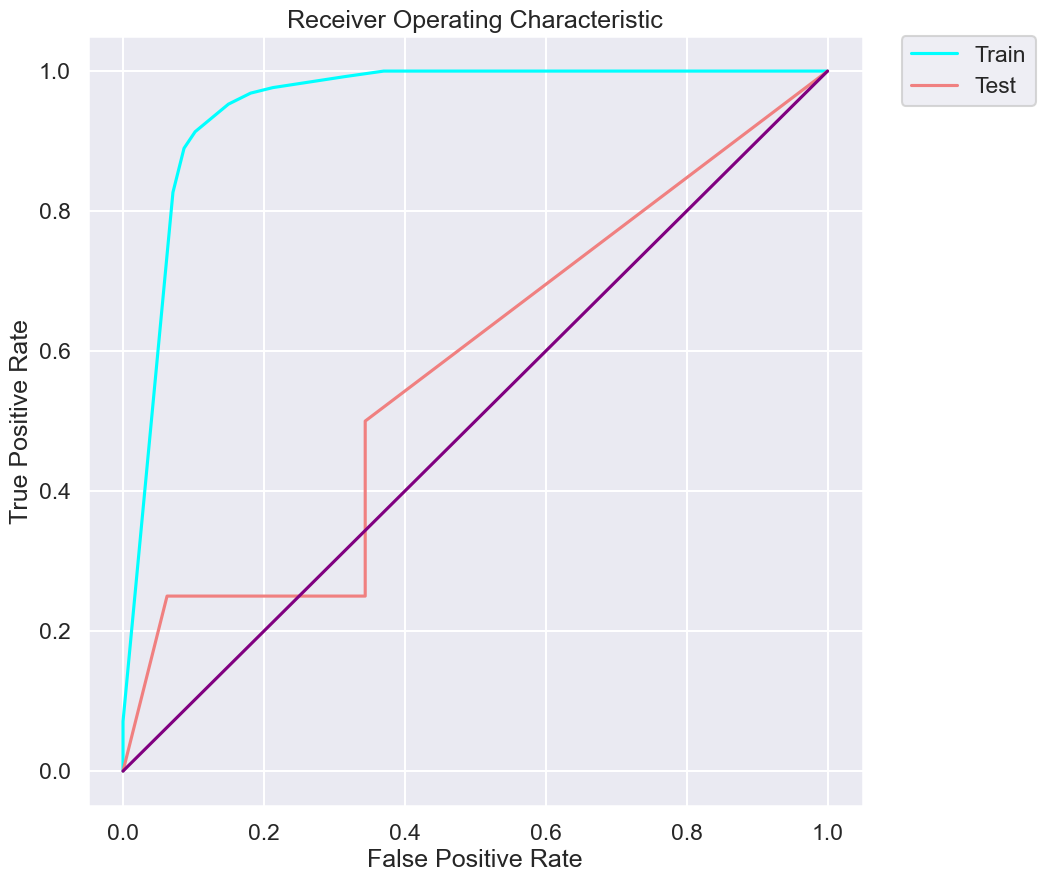

In [88]:
model_roc(y_train_os,y_test,dt_train_probability,dt_test_probability)

In [89]:
pickle.dump(dt_best, open('./final_statsbomb_data/data_modeling/dt.pkl','wb'))

## Compare Models

In [90]:
model_names = ['Logistic Regression','K Neighbors','Decision Tree']

model_comparison = pd.DataFrame(model_names, columns = ['Model'])

models = [lr,kn,dt]

probabilities = [lr_test_probability,kn_test_probability,dt_test_probability]

predictions = [lr_test_predict,kn_test_predict,dt_test_predict]

recall_scores = []
for p in predictions:
    recall_scores.append(round((recall_score(y_test, p)), 2))

model_comparison['Recall'] = recall_scores

roc_scores = []
for p in probabilities:
    roc_scores.append(round((roc_auc_score(y_test, p[:,1])), 2))

model_comparison['ROC'] = roc_scores

accuracy_scores = []
for p in predictions:
    accuracy_scores.append(round((accuracy_score(y_test, p)), 2))

model_comparison['Accuracy'] = accuracy_scores

model_comparison.sort_values('Recall',ascending = False,inplace = True)

model_comparison

,Model,Recall,ROC,Accuracy
0,Logistic Regression,0.50,0.73,0.81
1,K Neighbors,0.25,0.72,0.72
2,Decision Tree,0.25,0.57,0.81


Logistic regression seems to be performing the best across all 3 categories

## Ensemble Models

Bagging: An ensemble estimator which fits multiple base decision trees, on random subsets, then aggregates the individual predictions.


In [91]:
bc = BaggingClassifier(random_state = 13)

# Use Grid Search to find the best base decision tree
bc_params = {'base_estimator' : [dt_best, lr_best]}
model_grid(bc, bc_params)

# Refine bc parameters for Grid Search
bc_best = BaggingClassifier(base_estimator = dt_best,random_state = 13)
bc_params = {'n_estimators' : [10, 50, 100]}

# Use Grid Search to find the best parameters for bc
model_grid(bc, bc_params)

# Define best paramters for bc
bc_best = BaggingClassifier(base_estimator = dt_best,n_estimators = 10,random_state = 13)

bc_best.fit(X_train_os,y_train_os)

# Produce predictions and probabilities
bc_train_predict = bc_best.predict(X_train_os)
bc_train_probability = bc_best.predict_proba(X_train_os)
bc_test_predict = bc_best.predict(X_test)
bc_test_probability = bc_best.predict_proba(X_test)

print('Train Report')
model_report(y_train_os,bc_train_predict)

print('Test Report')
model_report(y_test,bc_test_predict)

{'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                        min_samples_split=10, random_state=13)}

{'n_estimators': 100}

Train Report


,0,1,accuracy,macro avg,weighted avg
precision,0.941176,0.888889,0.913386,0.915033,0.915033
recall,0.881890,0.944882,0.913386,0.913386,0.913386
f1-score,0.910569,0.916031,0.913386,0.913300,0.913300
support,127.000000,127.000000,0.913386,254.000000,254.000000


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.909091,0.333333,0.861111,0.621212,0.845118
recall,0.937500,0.250000,0.861111,0.593750,0.861111
f1-score,0.923077,0.285714,0.861111,0.604396,0.852259
support,32.000000,4.000000,0.861111,36.000000,36.000000


Train - Area Under the Curve: 0.97
Test - Area Under the Curve: 0.62


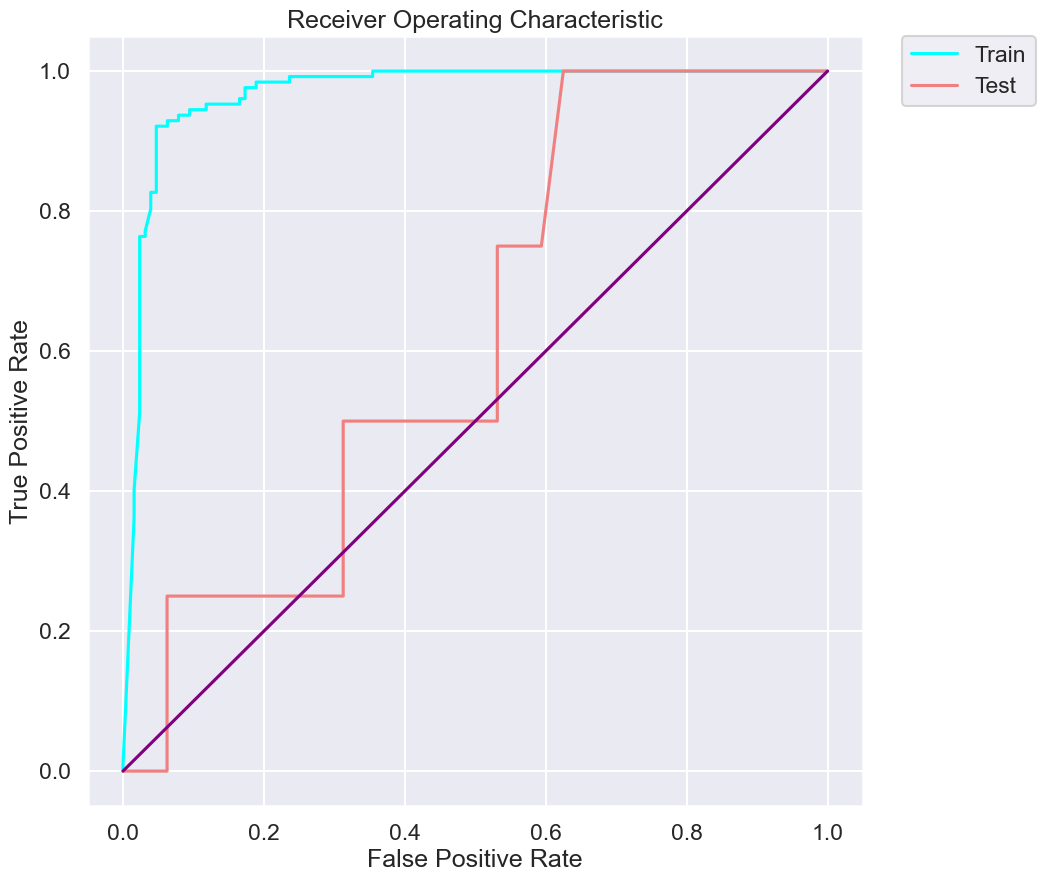

In [92]:
model_roc(y_train_os,y_test,bc_train_probability,bc_test_probability)

In [93]:
pickle.dump(bc, open('./final_statsbomb_data/data_modeling/bc.pkl','wb'))

Voting Classifier: A model which trains an ensemble of multiple models and predicts each feature based on the model with the highest probability.

Use a voting classifier to attempt to improve the predictive quality of the modeling through averaging the individual models which have performed best so far Summing the predicted probabilities for classes, then predicting the class with the largest sum probability.

In [94]:
estimators = [('kn', kn_best),('lr', lr_best)]

vc = VotingClassifier(estimators,
                      voting = 'soft')

vc.fit(X_train_os,y_train_os)

# Produce predictions and probabilities
vc_train_predict = vc.predict(X_train_os)
vc_train_probability = vc.predict_proba(X_train_os)
vc_test_predict = vc.predict(X_test)
vc_test_probability = vc.predict_proba(X_test)

print('Train Report')
model_report(y_train_os,vc_train_predict)

print('Test Report')
model_report(y_test,vc_test_predict)

Train Report


,0,1,accuracy,macro avg,weighted avg
precision,0.920792,0.777778,0.834646,0.849285,0.849285
recall,0.732283,0.937008,0.834646,0.834646,0.834646
f1-score,0.815789,0.850000,0.834646,0.832895,0.832895
support,127.000000,127.000000,0.834646,254.000000,254.000000


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.896552,0.142857,0.75,0.519704,0.812808
recall,0.812500,0.250000,0.75,0.531250,0.750000
f1-score,0.852459,0.181818,0.75,0.517139,0.777943
support,32.000000,4.000000,0.75,36.000000,36.000000


Train - Area Under the Curve: 0.93
Test - Area Under the Curve: 0.73


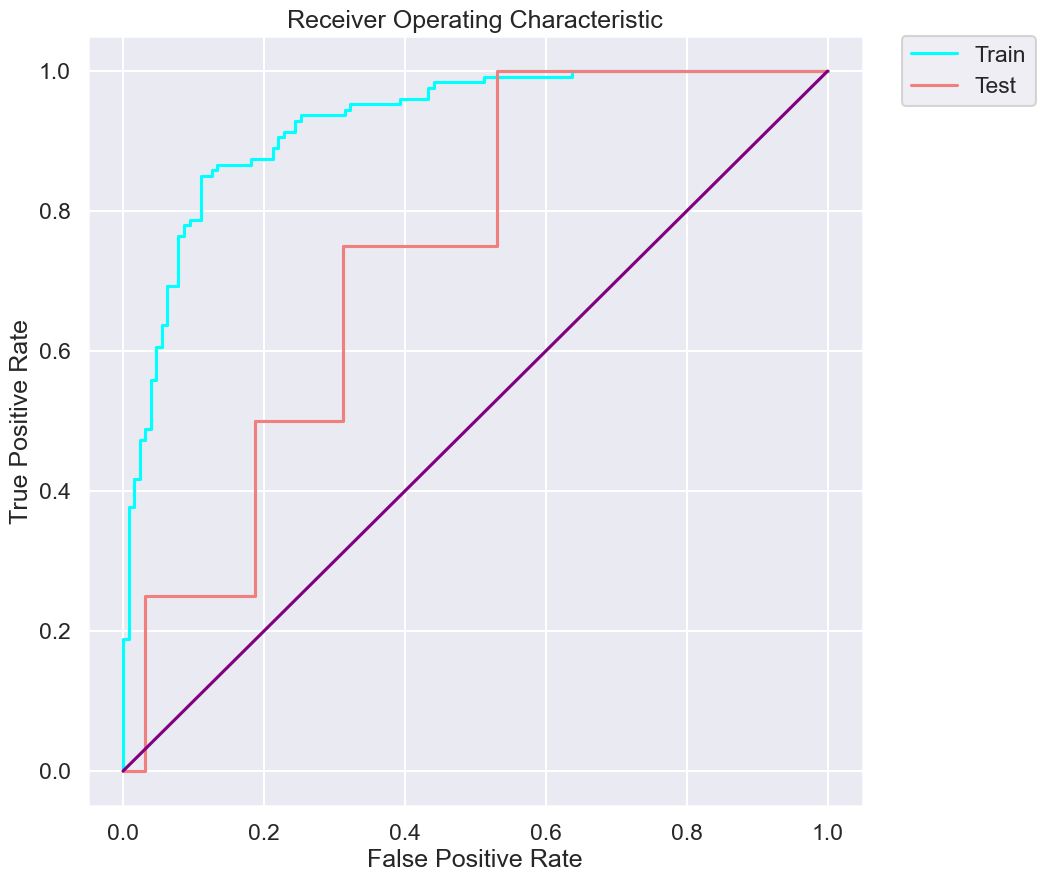

In [95]:
model_roc(y_train_os,y_test,vc_train_probability,vc_test_probability)

In [96]:
pickle.dump(vc, open('./final_statsbomb_data/data_modeling/vc.pkl','wb'))

## Compare Models

In [97]:
model_names = ['Logistic Regression','K Neighbors','Decision Tree', 'Bagging Classifier', 'Voting Classifier']

model_comparison = pd.DataFrame(model_names, columns = ['Model'])

models = [lr,kn,dt,bc,vc]

probabilities = [lr_test_probability, kn_test_probability, dt_test_probability, bc_test_probability, vc_test_probability]

predictions = [lr_test_predict,kn_test_predict,dt_test_predict,bc_test_predict,vc_test_predict]

recall_scores = []
for p in predictions:
    recall_scores.append(round((recall_score(y_test, p)), 2))

model_comparison['Recall'] = recall_scores

roc_scores = []
for p in probabilities:
    roc_scores.append(round((roc_auc_score(y_test, p[:,1])), 2))

model_comparison['ROC'] = roc_scores

accuracy_scores = []
for p in predictions:
    accuracy_scores.append(round((accuracy_score(y_test, p)), 2))

model_comparison['Accuracy'] = accuracy_scores

model_comparison.sort_values('Recall', ascending = False, inplace = True)

model_comparison

,Model,Recall,ROC,Accuracy
0,Logistic Regression,0.50,0.73,0.81
1,K Neighbors,0.25,0.72,0.72
2,Decision Tree,0.25,0.57,0.81
3,Bagging Classifier,0.25,0.62,0.86
4,Voting Classifier,0.25,0.73,0.75


BC beats out LR in accuracy by a little bit, but overall LR still performs the best when looking across all 3

## Feature Selection

In [98]:
# feature importance
def model_fi(model):
    model.fit(X_train_os, y_train_os)
    predictions = model.predict(X_test)
    
    # Use absolute values of the coefficients as feature importance
    fi = (pd.DataFrame(abs(model.coef_[0]),
                       index = X_test.columns, 
                       columns = ['importance']).sort_values('importance',
                                                             ascending = False))
    fig, ax = plt.subplots(figsize = (10, 20))
    sns.barplot(x = 'importance', y = fi.index, 
                data = fi, color = 'purple')
    ax.set_title('Feature Importance')
    plt.show()

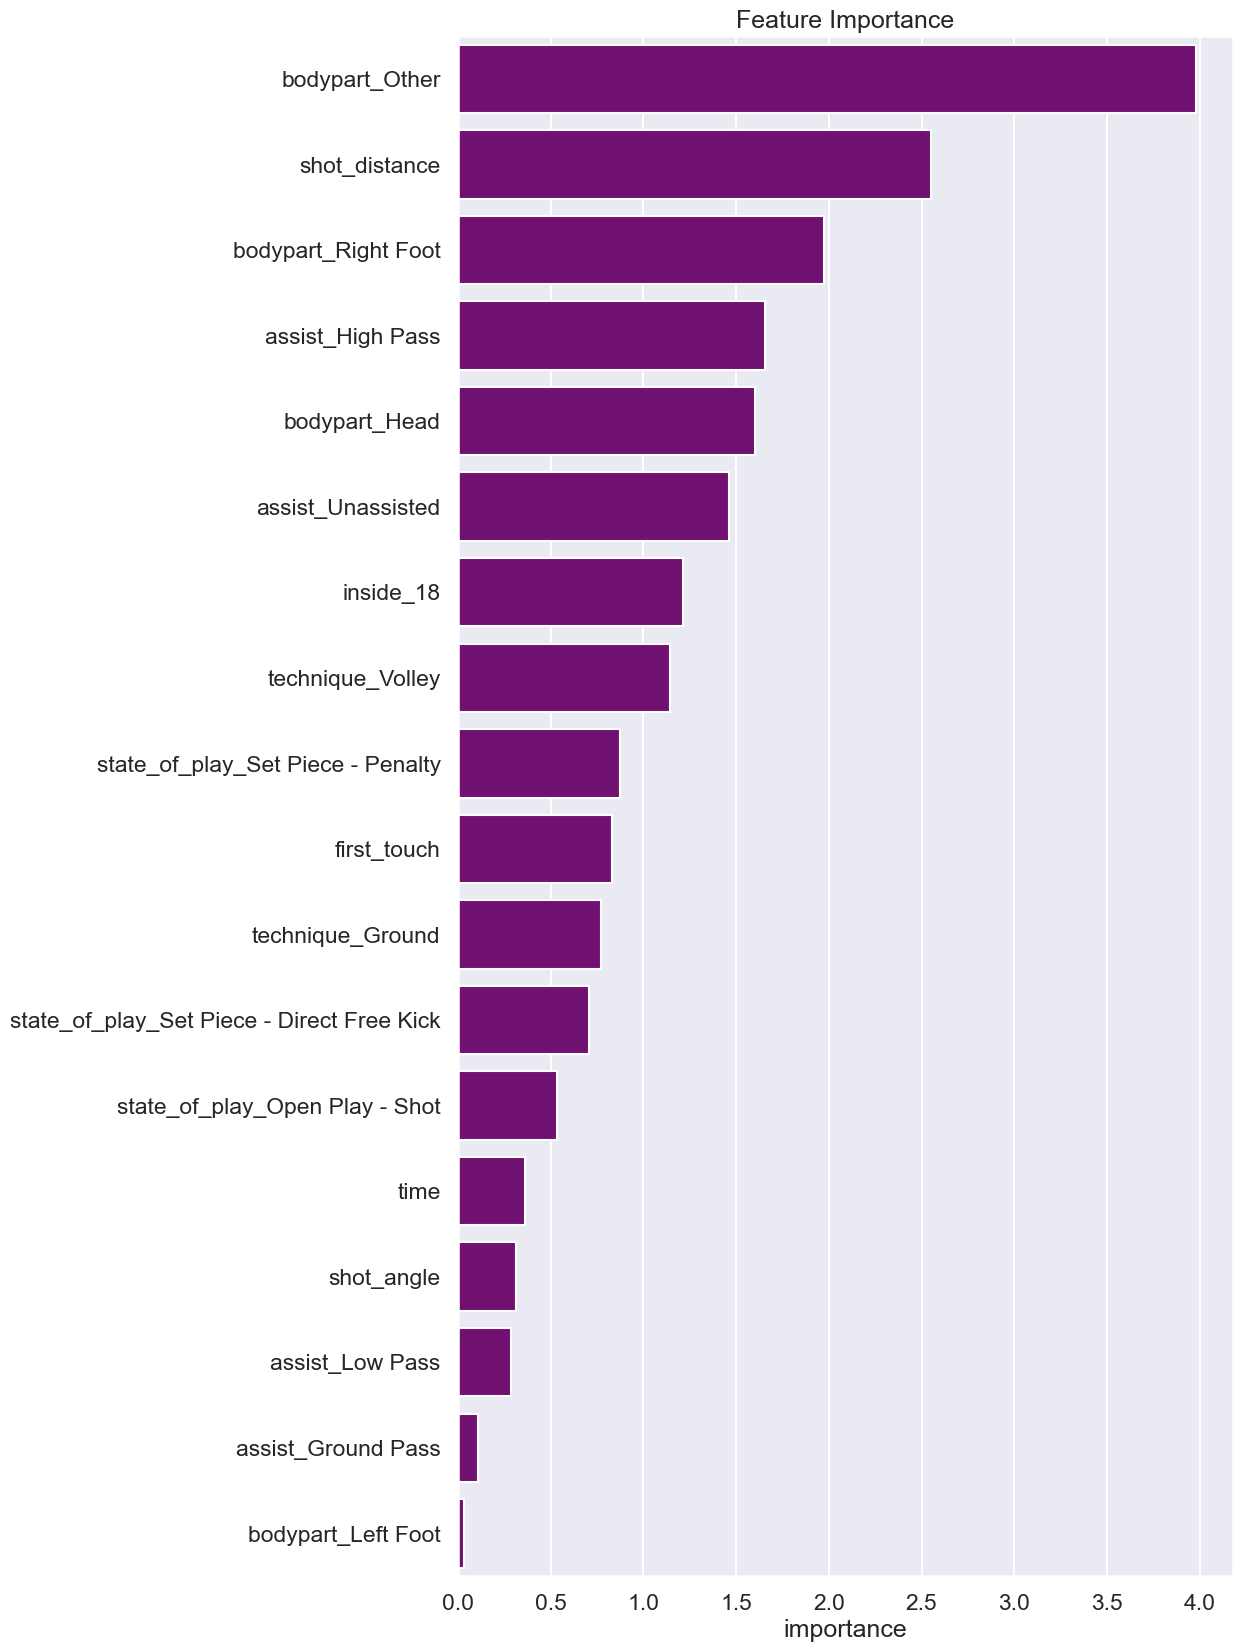

In [99]:
model_fi(lr_best)

In [100]:
# Use SelectKBest to select the top 5 features
selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(X_train_os, y_train_os)

# Transform the datasets using the selected features
X_train_rfe = selector.transform(X_train_os)
X_test_rfe = selector.transform(X_test)

# Fit the model on the transformed dataset
kn_best.fit(X_train_rfe, y_train_os)

# Produce predictions and probabilities
kn_train_predict = kn_best.predict(X_train_rfe)
kn_train_probability = kn_best.predict_proba(X_train_rfe)
kn_test_predict = kn_best.predict(X_test_rfe)
kn_test_probability = kn_best.predict_proba(X_test_rfe)

print('Train Report')
model_report(y_train_os, kn_train_predict)

print('Test Report')
model_report(y_test, kn_test_predict)


Train Report


,0,1,accuracy,macro avg,weighted avg
precision,0.846847,0.769231,0.80315,0.808039,0.808039
recall,0.740157,0.866142,0.80315,0.803150,0.803150
f1-score,0.789916,0.814815,0.80315,0.802365,0.802365
support,127.000000,127.000000,0.80315,254.000000,254.000000


Test Report


,0,1,accuracy,macro avg,weighted avg
precision,0.900000,0.166667,0.777778,0.533333,0.818519
recall,0.843750,0.250000,0.777778,0.546875,0.777778
f1-score,0.870968,0.200000,0.777778,0.535484,0.796416
support,32.000000,4.000000,0.777778,36.000000,36.000000


Train - Area Under the Curve: 0.91
Test - Area Under the Curve: 0.71


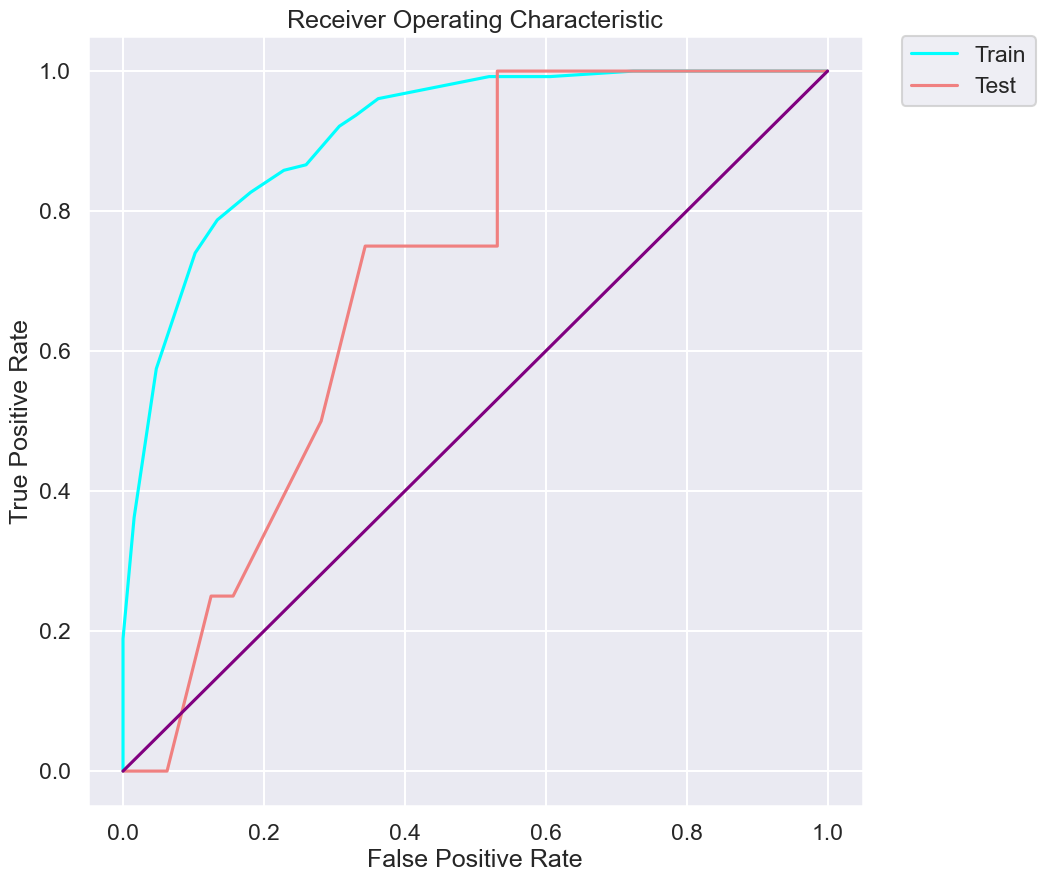

In [101]:
model_roc(y_train_os,y_test,kn_train_probability,kn_test_probability)

Further feature selection has not improved the top performing models, so we will use the original feature set.

# Part 8: Conclusion

See PDF of Presentation and Conclusions here: https://drive.google.com/drive/folders/1gvLBYRPJz1TxnFi8dA54B-hcq1K4aCnp?usp=share_link 